# Notes

# Imports

In [1]:
%%time
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from lmfit import minimize, Parameter, Parameters, report_fit
from IPython import display
from IPython.display import HTML
import datetime
#from progressbar import progressbar
#from numba import jit


CPU times: total: 1.59 s
Wall time: 1.57 s


In [2]:
HTML("<style>.container { width:100% !important; }</style>")

# Model diagram

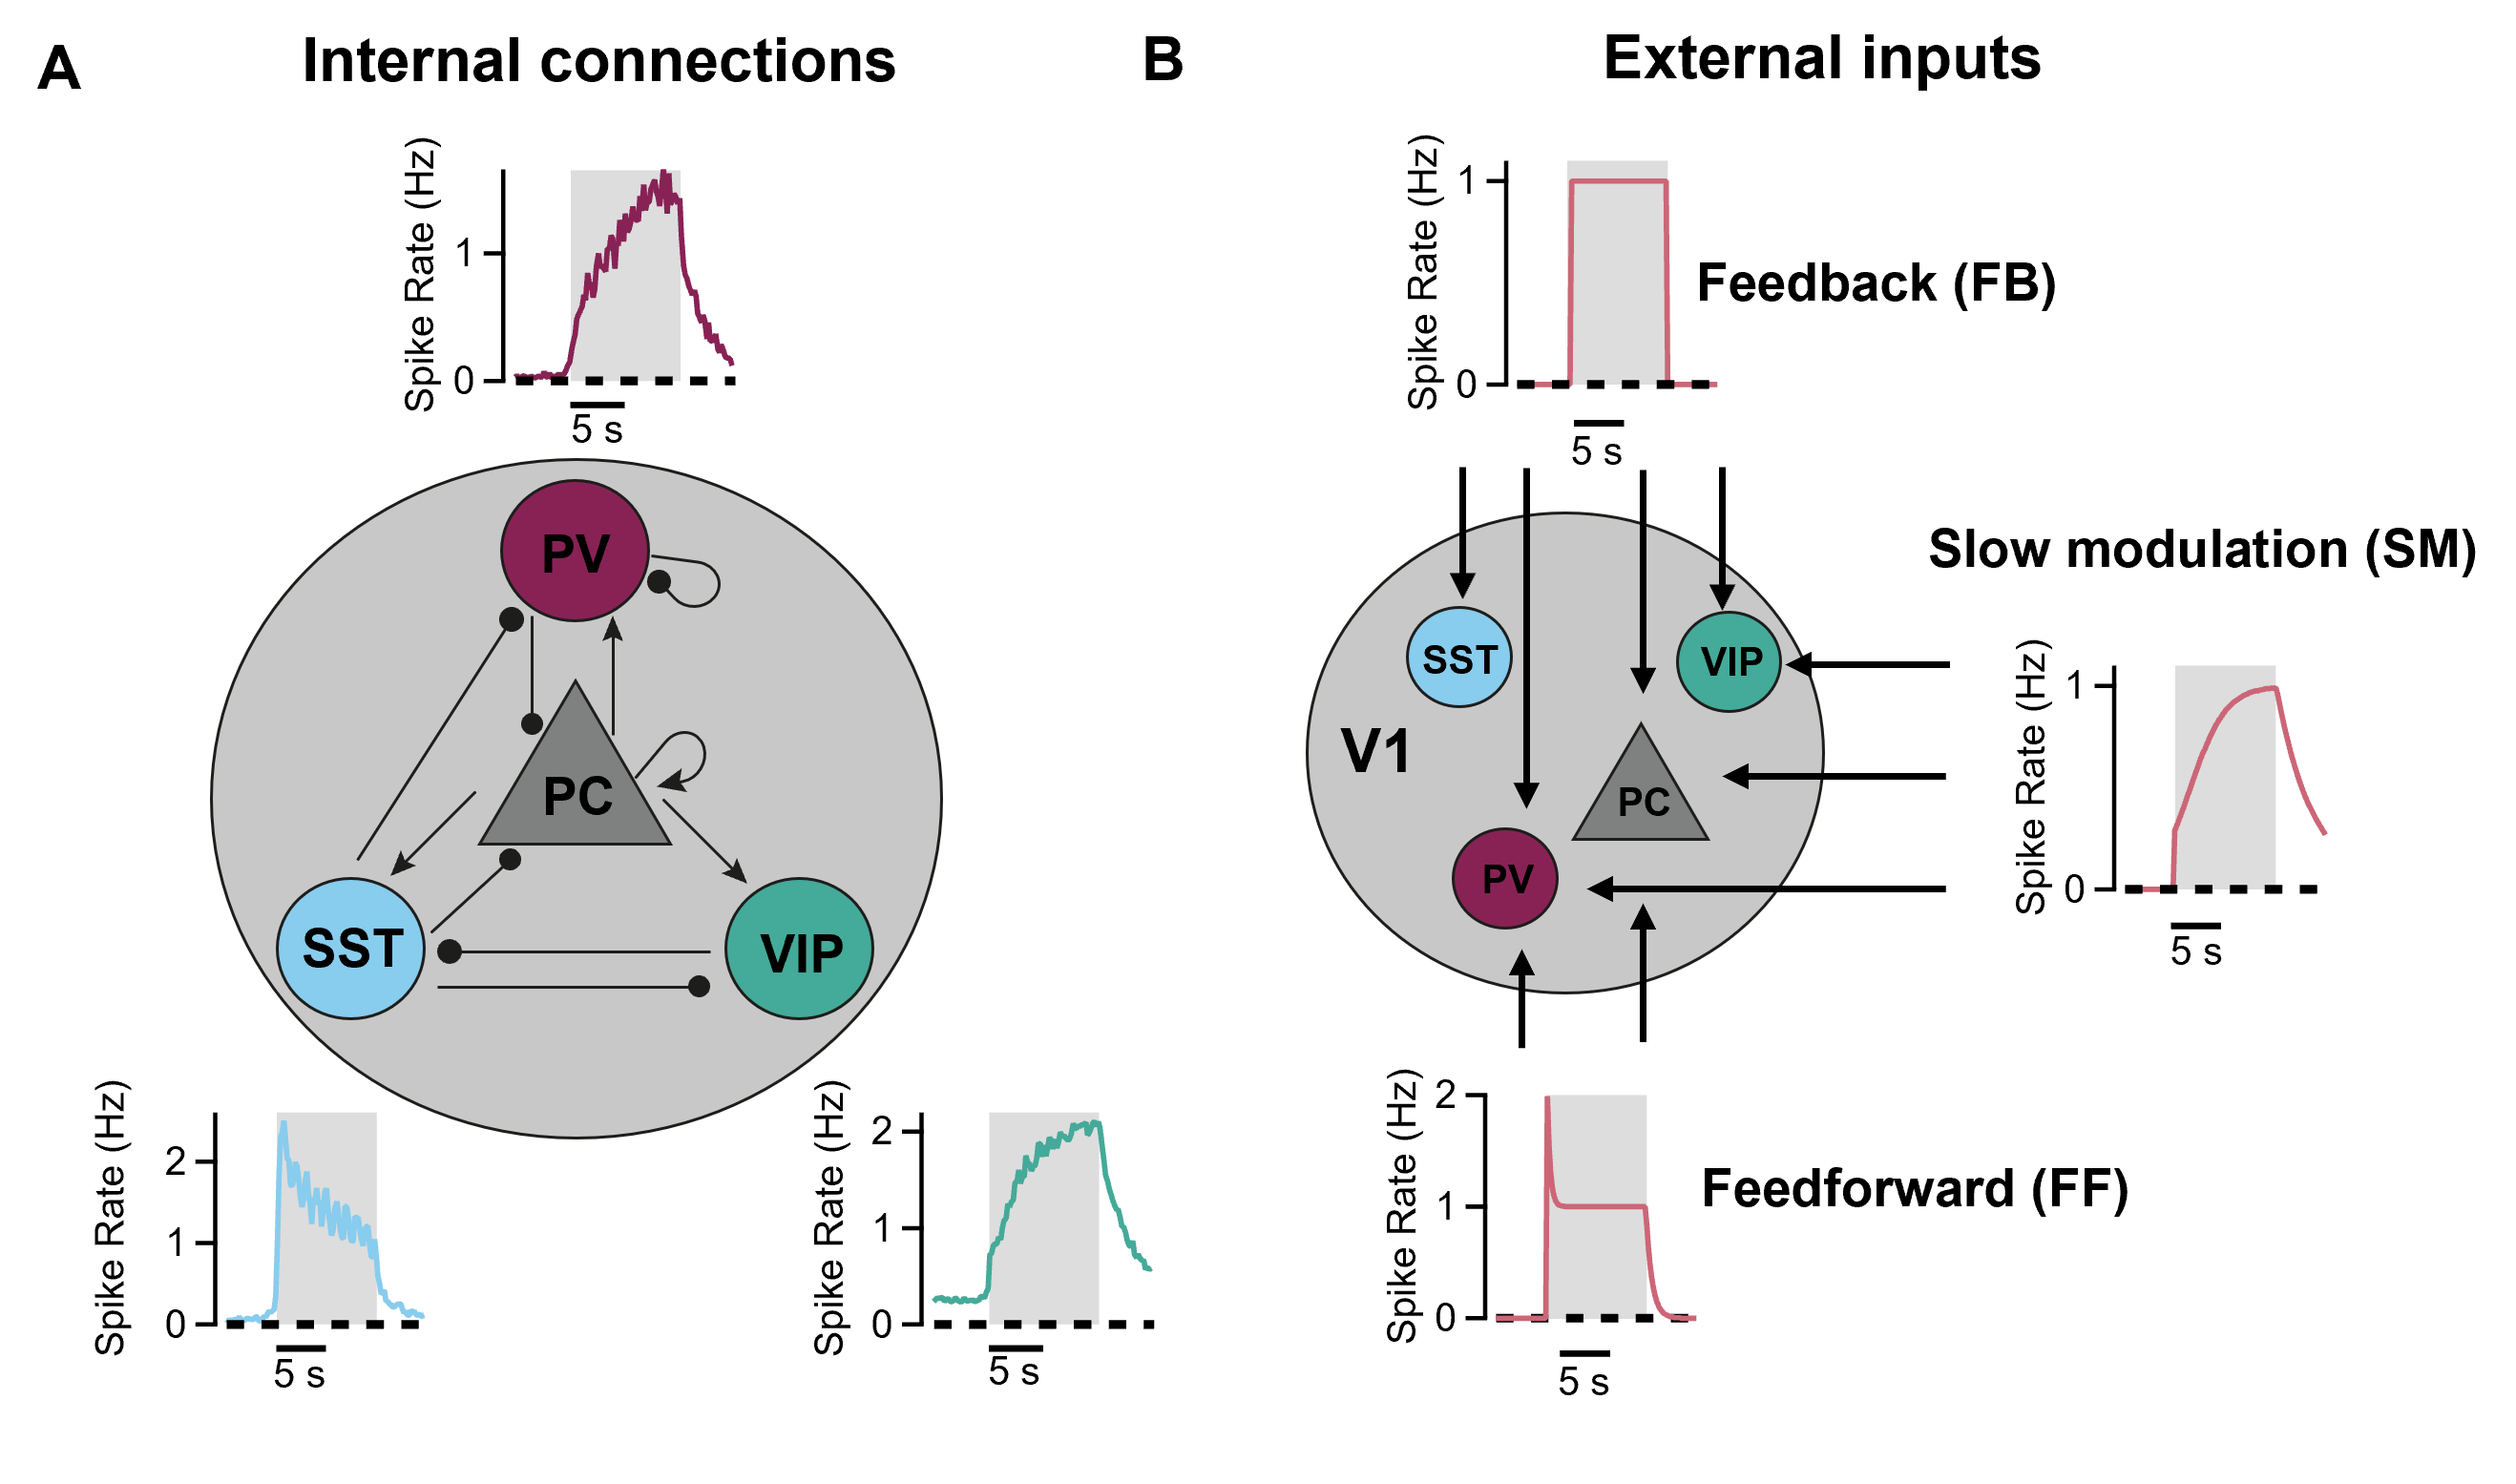

In [3]:
display.Image(r'Model_diagram.png')

# Functions

In [4]:
def Step(t, stim = 5, inter = 10, amp = 1.0, base = 0, k = 0, delay = 0, decay_f = 0):
    """
    Feedback (FB) input:
    ------------------------------------
    Represented as a step function. Returns value of the input function in a time point t.
    ------------------------------------
    Parameters:
    
    t (running)             - time in seconds;
    stim (fixed) = 5 s      - time of the stimulus start;
    inter (fixed) = 10 s    - duration of the stimulus;
    amp (fixed) = 1.0 Hz    - amplitude of response;
    base (fixed) = 0 Hz     - baseline activity;
    k (fixed) = 0           - slope of the slow component. Used to be varied while testing linear depression or sensitization component in the FB input;
    delay (variable)        - delay of the FB input to the cell relative to the stimulus start;

    """
    
    if (t < stim + delay):
        h = base
    elif (t > stim + inter):
        h = amp * np.exp(-(t - stim - inter)*decay_f)
    else:
        h = amp*(t - stim - delay)*k*0.164745 + amp
    
    return h

In [5]:
def Sigm(t, stim = 5, inter = 10, ampl = 1.0, base = 0, rate = 1, delay = 0, decay_s = 1):
    """
    Slow modulation (SM) input:
    ------------------------------------
    Represented as a sigmoid function. Returns value of the input function in a time point t.
    ------------------------------------
    Parameters:
    
    t (running)               - time in seconds;
    stim (fixed) = 5 s        - time of the stimulus start;
    inter (fixed) = 10 s      - duration of the stimulus;
    ampl (fixed) = 1.0 Hz     - amplitude of response;
    base (fixed) = 0 Hz       - baseline activity;
    rate (variable)           - time-constant of the SM input;
    delay (variable)          - shift of the sigmoid center relative to stimulus start;
    decay_s (varaible)        - time-constant of the SM input exponential decay after the end of stimulation;

    """
    
    if (t < stim):
        h = base
    elif (t > stim + inter):
        h = (base + (ampl/(1 + np.exp((delay-inter)/rate))))*np.exp(-(t - stim - inter)*decay_s) + base
    
    else:
        h = base + (ampl/(1 + np.exp((stim + delay - t)/rate))) #Actualy rate here is time constant, where 1/rate is actual rate
        
    
    return h

In [6]:
def expon(t, stim = 5, inter = 10, ampl = 1.5, base = 0, decay = 1, delay = 0, b = 0, decay_ff = 0, s_start = 0.1, k = 0.1):
    """
    Feedforward (FF) input:
    ------------------------------------
    Represented as a flat step function with fast exponential decay on the stimulus start and linear increase during 10 second period. 
    Returns value of the input function in a time point t.
    ------------------------------------
    Parameters:
    
    t (running)               - time in seconds;
    stim (fixed) = 5 s        - time of the stimulus start;
    inter (fixed) = 10 s      - duration of the stimulus;
    ampl (variable)           - amplitude of peak;
    base (fixed) = 1 Hz       - steady-state firing rate after fast exponential depression;
    decay (variable)          - time-constant of the fast exponential depression;
    delay (variable)          - delay of the FF input to the cell relative to the stimulus start;
    b (fixed) = 0 Hz          - baseline activity;
    decay_ff (varaible)       - time-constant of the FF input exponential decay after the end of stimulation;
    s_start (varaible)        - delay after stimulus when linear modulation starts;
    k (varaible)              - slope of the slow linear modulation;

    """
    
    if (t < stim + delay):
        h = b
    elif (t > stim + inter):
        h = (b + base + ampl*np.exp(-(inter-delay)*decay)+ (inter - delay - s_start)*k)*np.exp(-(t - stim - inter)*decay_ff)
    elif ((t >= stim + delay) and (t < stim + delay + s_start)):
        h = b + base + ampl*np.exp(-(t - stim - delay)*decay)
    else:
        h = b + base + ampl*np.exp(-(t - stim - delay)*decay)+ ((t - stim - delay - s_start)*k)
        
    return h

In [7]:
# @jit(parallel=True, fastmath=True)
def model_step(t,
               y,
               w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18,
               tau_0, tau_1, tau_2, tau_3,
               threshold,
               power,
               q,
               i_0, i_1, i_2, i_3,
               r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k,
               i_d_0, w_d_0, w_d_1, w_d_2, w_d_3, w_d_4, w_d_5
               ):
    """
    Model basis:
    ------------------------------------
    Systems of first order differential equations that captures activity of populations without (df_xdt) and with (df_x_odt) optogenetic manipulations. 
    Returns an array of values of the derrivatives at a certain timepoint, calculated from values of functions in previous timepoint. 
    ------------------------------------
    Parameters:
    
    t (running)               - time in seconds;
    y (running)               - values of activities on the previous timepoint;
    w_x (variable)            - synaptic weights;
    tau_x (fixed)             - neurons time-constants;
    threshold (fixed) = 0 Hz  - minimum rectification value;
    power (fixed) = 2         - value of the power in the input-output function;
    q (fixed) = 1             - normalization coeficient in the input-output function;
    i_x (variable)            - baseline activity of neurons;
    ...
    i_d_0, w_d_0, w_d_1, w_d_2, w_d_3, w_d_4, w_d_5 are variables that correspond to PC subpopulation
    
    """
    
            
    f_e, f_p, f_s, f_v, f_e_o, f_p_o, f_s_o, f_v_o, f_e_d, f_e_do = y
    
    ff_e = (min(max((i_0 + w_0 * f_e + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_3 * f_p - w_4 * f_s), threshold), 25))
    ff_e_d = (min(max((i_d_0 + w_d_0 * f_e + w_d_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_d_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_d_3 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_d_4 * f_p - w_d_5 * f_s), threshold), 25))
    ff_p = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_5 * f_e + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p - w_9 * f_s), threshold), 25))
    ff_s = (min(max((i_2 + w_10 * f_e + w_11 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_12 * f_v), threshold), 25))
    ff_v = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_13 * f_e - w_14 * f_s +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))
        
    ff_e_o = (min(max((i_0 + w_0 * f_e_o + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_3 * f_p_o - w_4 * f_s_o), threshold), 25))
    ff_e_do = (min(max((i_d_0 + w_d_0 * f_e_o + w_d_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_d_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_d_3 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_d_4 * f_p_o - w_d_5 * f_s_o), threshold), 25))
    ff_p_o = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_5 * f_e_o + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p_o - w_9 * f_s_o), threshold), 25)) #*invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1, delta = 1) *Step_1(t, k=-0.2) Step_1(t, amp = 1.0, k=-0.13) exp_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.01, amp = 1) *invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1)
    ff_s_o = (min(max((i_2 + w_10 * f_e_o + w_11 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_12 * f_v_o), threshold), 25))
    ff_v_o = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_13 * f_e_o - w_14 * f_s_o +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))
    
        
    df_edt = ((q * ff_e ** power) - f_e) / tau_0
    df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
    df_pdt = ((q * ff_p ** power) - f_p) / tau_1
    df_sdt = ((q * ff_s ** power) - f_s) / tau_2
    df_vdt = ((q * ff_v ** power) - f_v) / tau_3
    
    if (t>=5): #and (t<=15):

        # Here is where opto effect is implemented by multiplication or division of value by cirtain constant.
        # Currently it is PV Chr by 2.0 multiplication
        
        df_e_odt = ((q * (ff_e_o) ** power) - f_e_o) / tau_0
        df_e_dodt = ((q * ff_e_do ** power) - f_e_do) / tau_0
        df_p_odt = ((q * (ff_p_o*2.0) ** power) - f_p_o) / tau_1 #/1.5
        df_s_odt = ((q * (ff_s_o) ** power) - f_s_o) / tau_2 #/1.5
        df_v_odt = ((q * (ff_v_o) ** power) - f_v_o) / tau_3
        
    else:
        
        df_e_odt = ((q * (ff_e_o) ** power) - f_e_o) / tau_0
        df_e_dodt = ((q * ff_e_do ** power) - f_e_do) / tau_0
        df_p_odt = ((q * (ff_p_o) ** power) - f_p_o) / tau_1
        df_s_odt = ((q * (ff_s_o) ** power) - f_s_o) / tau_2
        df_v_odt = ((q * (ff_v_o) ** power) - f_v_o) / tau_3
    

    dydt = [df_edt, df_pdt, df_sdt, df_vdt, df_e_odt, df_p_odt, df_s_odt, df_v_odt, df_e_ddt, df_e_dodt]
    
    return dydt

In [8]:
names = ['w_PC_PC', # w_0
         'w_EX_PC', # w_1
         'w_SI_PC', # w_2
         'w_PV_PC', # w_3
         'w_SS_PC', # w_4
         'w_PC_PV', # w_5
         'w_EX_PV', # w_6
         'w_SI_PV', # w_7
         'w_PV_PV', # w_8
         'w_SS_PV', # w_9
         'w_PC_SS', # w_10
         'w_ST_SS', # w_11
         'w_VI_SS', # w_12
         'w_PC_VI', # w_13
         'w_SS_VI', # w_14
         'w_SI_VI', # w_15
         'w_ST_PC', # w_16
         'w_PC_PC', # w_17
         'w_PC_PC', # w_18
         'w_PC_PC', # w_19
         'w_PC_PC'] # w_20

In [9]:
#@njit(parallel=True, fastmath=True)
def exp_time(start, step, count, endpoint=False):
    """
    Experimental timepoints calculation:
    ------------------------------------
    Returns an array of values of the experimental timepoints. 
    ------------------------------------
    Parameters:
    
    start              - starting point;
    step               - value of time step of experimental recordings;
    count              - number of points;
    
    """
    stop = start+(step*count)
    return np.linspace(start, stop, count, endpoint=endpoint)

In [10]:
#@jit(parallel=True, fastmath=True)
def odesol_step(tt, init, params): 
    """
    Solves differential equation system defined in model_step() function.
    """
    y_init = init
    w_0 = params['w_0'].value
    w_1 = params['w_1'].value
    w_2 = params['w_2'].value
    w_3 = params['w_3'].value
    w_4 = params['w_4'].value
    w_5 = params['w_5'].value
    w_6 = params['w_6'].value
    w_7 = params['w_7'].value
    w_8 = params['w_8'].value
    w_9 = params['w_9'].value
    w_10 = params['w_10'].value
    w_11 = params['w_11'].value
    w_12 = params['w_12'].value
    w_13 = params['w_13'].value
    w_14 = params['w_14'].value
    w_15 = params['w_15'].value
    w_16 = params['w_16'].value
    w_17 = params['w_17'].value
    w_18 = params['w_18'].value
    
    tau_0 = params['tau_0'].value
    tau_1 = params['tau_1'].value
    tau_2 = params['tau_2'].value
    tau_3 = params['tau_3'].value
    threshold = params['threshold'].value
    power = params['power'].value
    q = params['q'].value
    i_0 = params['i_0'].value
    i_1 = params['i_1'].value
    i_2 = params['i_2'].value
    i_3 = params['i_3'].value
    ampl_1 = params['ampl_1'].value

    r_1 = params['r_1'].value
    delay_1 = params['delay_1'].value
    delay_2 = params['delay_2'].value
    delay_3 = params['delay_3'].value
    decay = params['decay'].value
    decay_s = params['decay_s'].value
    decay_f = params['decay_f'].value
    decay_ff = params['decay_ff'].value
    ampl = params['ampl'].value
    base = params['base'].value
    base_sigm = params['base_sigm'].value
    s_start = params['s_start'].value
    k = params['k'].value

    i_d_0 = params['i_d_0'].value
    w_d_0 = params['w_d_0'].value
    w_d_1 = params['w_d_1'].value
    w_d_2 = params['w_d_2'].value
    w_d_3 = params['w_d_3'].value
    w_d_4 = params['w_d_4'].value
    w_d_5 = params['w_d_5'].value
   
    
    
    sol = solve_ivp(lambda t, y: model_step(t, y, 
                                            w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                                            tau_0, tau_1, tau_2, tau_3,
                                            threshold,
                                            power, 
                                            q,
                                            i_0, i_1, i_2, i_3,
                                            r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k,
                                            i_d_0, w_d_0, w_d_1, w_d_2, w_d_3, w_d_4, w_d_5
                                           ), 
                    [tt[0], tt[-1]],
                    y_init,
                    method='RK45',
                    t_eval=tt,
                    #rtol = 1e-10, atol = 1e-12
                   )
    
    
    return sol

In [11]:
def simulate_step(tt, init, params):
    """
    Model simulation:
    ------------------------------------
    Returns a Pandas DataFrame of timesteps and populational activity traces with and without optogenetic. 
    ------------------------------------
    Parameters:
    
    tt (running)        - current timepoint;
    init (fixed)        - intial conditions for differential equations;
    params              - lmfit.Parameters() object with all parameters from the differential equations systems
    """

    sol = odesol_step(tt, init, params)
    
    dd = np.vstack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5], sol.y[6], sol.y[7], sol.y[8], sol.y[9])).T
    sim = pd.DataFrame(dd, columns=['t', 'f_e', 'f_pv', 'f_sst', 'f_vip', 'f_e_o', 'f_pv_o', 'f_sst_o', 'f_vip_o', 'f_e_d', 'f_e_do'])
    
    return sim

In [12]:
def residual_ad(params, tt, init, data_pc_sen):
    """
    Residual function for fitting algorythms:
    ------------------------------------
    Returns flattened and concatenated array of residuals between model simulation and datapoints. Only PC subpopulation in this case. 
    ------------------------------------
    Parameters:
    
    params              - lmfit.Parameters() object with all parameters from the differential equations systems
    tt (running)        - current timepoint;
    init (fixed)        - intial conditions for differential equations;
    data_pc_sen         - PC subpopulation experimental data trace;
    """
    global count, max_nfev

    #
    # Weights initialization. Weights of 0.05 represents regions of traces smoothed by deconvolution algorythm. 
    #
    
    weights_pc = np.float32(np.zeros_like(data_pc_sen))
    weights_pc[0:24] = 1.
    weights_pc[24:30] = 0.05
    weights_pc[30:38] = 1.
    weights_pc[38:] = 1.
    
    model = simulate_step(tt, init, params)
    pc_d_r = (np.array(model['f_e_d'].values - data_pc_sen)*weights_pc).ravel()

    #
    # Block of code to update and plot fits every step of fitting function
    #
    
    display.clear_output(wait=True)
    plt.figure(figsize = (15,5))
    plt.plot(t_exp, data_pc_sen, color='black', marker='o', label='f_pc(t)')
    plt.plot(t_exp, model['f_e_d'].values, color='blue', label='fit', linewidth=3)
    plt.title('leastsq_PC')
    plt.legend(loc='best')
    plt.xlabel('t')
    #plt.ylim(0, 1.2)
    plt.xticks(np.arange(0,21,1))
    plt.grid()
    text = str(count) + ' ' + '/' + ' ' + str(max_nfev) 
    
    bbox = dict(boxstyle='round', fc='white', ec='orange', alpha=0.5)
    plt.text(20.6, 0.45, text, fontsize=12, bbox=bbox, horizontalalignment='right')
    count += 1
    
    plt.show()
    
    return pc_d_r

In [13]:
def RMSE_full(params, init, data_pc, data_pv, data_sst, data_vip):
    """
    Root Mean Square Error (RMSE) calculation:
    ------------------------------------
    Returns RMSE value for full fit of 4 averages of populations: PC, PV, SST, VIP. 
    ------------------------------------
    Parameters:
    
    params              - lmfit.Parameters() object with all parameters from the differential equations systems
    init (fixed)        - intial conditions for differential equations;
    data_pc             - PC experimental data trace;
    data_pv             - PV experimental data trace;
    data_sst            - SST experimental data trace;
    data_vip            - VIP experimental data trace;
    
    """
    
    model = simulate_step(t_exp, init, params)
    sum = 0
    for i in range(len(data_pc)):
        sum += (model['f_e'].values[i] - data_pc[i])**2 + (model['f_pv'].values[i] - data_pv[i])**2 + (model['f_sst'].values[i] - data_sst[i])**2 + (model['f_vip'].values[i] - data_vip[i])**2

    sum = np.sqrt((sum)/(len(data_pc)*4))

    return sum

In [14]:
def RMSE(params, init, data, type):
    """
    Root Mean Square Error (RMSE) calculation:
    ------------------------------------
    Returns RMSE value for one defined fit.
    ------------------------------------
    Parameters:
    
    params              - lmfit.Parameters() object with all parameters from the differential equations systems
    init (fixed)        - intial conditions for differential equations;
    data                - Data to compare with fit;
    type                - desired type of model - one from defined in simulation function.
    
    """
    
    model = simulate_step(t_exp, init, params)
    sum = 0
    for i in range(len(data)):
        sum += (model[type].values[i] - data[i])**2

    sum = np.sqrt((sum)/len(data))

    return sum

# Experimental data

In [15]:
#timepoint
dt = 0.164745

# PC_sensitizers
pc_sen = np.loadtxt(r'Experimental data\Updated_again\B_QA_Norx2_Sen_Avg1_NoLoco.txt')
# PC_depressors
pc_dep = np.loadtxt(r'Experimental data\Updated_again\B_QA_Norx2_Dep_Avg1_NoLoco.txt')
# PC_intermediate
pc_na = np.loadtxt(r'Experimental data\Updated_again\B_QA_Norx2_NA_Avg1_NoLoco.txt')
# PC_whole_population
pc_all = np.loadtxt(r'Experimental data\Updated_again\QA_Avg_Sess1_PC_NoLoco.txt')
# PC_standard_errors
pc_sen_err = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_Sen_SEM.txt')
pc_dep_err = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_Dep_SEM.txt')
pc_na_err = np.loadtxt(r'Experimental data\Updated_again\QA_Norx2_PC_NA_SEM.txt')
pc_all_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PC_All_SEMSess1.txt')

t_exp_1 = exp_time(start=0.0, step=dt, count=len(pc_sen))
print(len(pc_sen), len(t_exp_1))

183 183


In [16]:
# PV_average (whole population)
pv = np.loadtxt(r'Experimental data\Updated_again\QA_Avg_Sess1_PV_NoLoco.txt')
# PV_average_standard_error
pv_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PV_SEMSess.txt')

t_pv_exp_1 = exp_time(start=0.0, step=dt, count=len(pv))
print(len(pv), len(t_pv_exp_1))

366 366


In [17]:
# SST_average (whole population)
sst = np.loadtxt(r'Experimental data\Updated_again\QA_Avg_Sess1_SST_NoLoco.txt')
# SST_average_standard_error
sst_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_SST_SEMSess.txt')

t_sst_exp_1 = exp_time(start=0.0, step=dt, count=len(sst))
print(len(sst), len(t_sst_exp_1))

366 366


In [18]:
# VIP_average (whole population)
vip = np.loadtxt(r'Experimental data\Updated_again\QA_Avg_Sess1_VIPPos_NoLoco.txt')
# VIP_average_standard_error
vip_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_VIP_SEMSess.txt')

t_vip_exp_1 = exp_time(start=0.0, step=dt, count=len(vip))
print(len(vip), len(t_vip_exp_1))

366 366


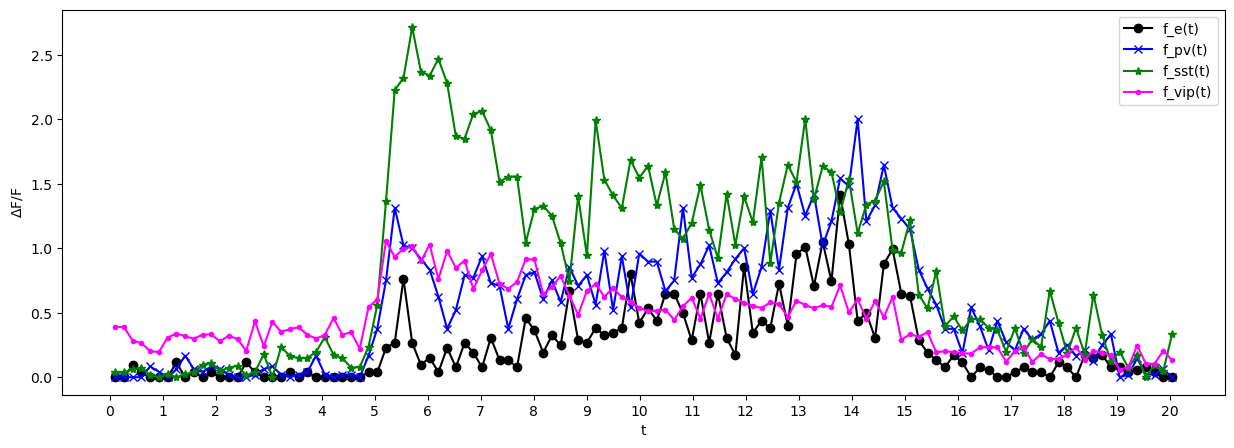

In [19]:
# Inicialization of new arrays to cut traces for suitable range

t_exp_1_new = []
pc_sen_new = []
pv_new = []
sst_new = []
vip_new = []
pc_na_new = []
pc_dep_new = []
pc_all_new = []
pc_sen_err_new = []
pc_dep_err_new = []
pc_na_err_new = []
pc_all_err_new = []
pv_err_new = []
sst_err_new = []
vip_err_new = []

# Cutting the traces
for ind, time in np.ndenumerate(t_exp_1):
    if (time >= 5) and (time <= 25):
        t_exp_1_new.append(time - 5)
        pc_sen_new.append(pc_sen[ind])
        pv_new.append(pv[ind])
        sst_new.append(sst[ind])
        vip_new.append(vip[ind])
        pc_na_new.append(pc_na[ind])
        pc_dep_new.append(pc_dep[ind])
        pc_all_new.append(pc_all[ind])
        pc_sen_err_new.append(pc_sen_err[ind])
        pc_dep_err_new.append(pc_dep_err[ind])
        pc_na_err_new.append(pc_na_err[ind])
        pv_err_new.append(pv_err[ind])
        sst_err_new.append(sst_err[ind])
        vip_err_new.append(vip_err[ind])
        pc_all_err_new.append(pc_all_err[ind])
        

# Adjusting for a missing initial point after deconvolution
pc_sen_new.insert(0, pc_sen_new[0])
pv_new.insert(0, pv_new[0])
sst_new.insert(0, sst_new[0])
vip_new.insert(0, vip_new[0])
pc_na_new.insert(0, pc_na_new[0])
pc_dep_new.insert(0, pc_dep_new[0])
pc_all_new.insert(0, pc_all_new[0])
pc_sen_err_new.insert(0, pc_sen_err_new[0])
pc_dep_err_new.insert(0, pc_dep_err_new[0])
pc_na_err_new.insert(0, pc_na_err_new[0])
pv_err_new.insert(0, pv_err_new[0])
sst_err_new.insert(0, sst_err_new[0])
vip_err_new.insert(0, vip_err_new[0])
pc_all_err_new.insert(0, pc_all_err_new[0])

t_exp_1_new.append(t_exp_1_new[-1] + dt)

# Plot traces
plt.figure(figsize=(15,5))
plt.plot(t_exp_1_new, pc_sen_new, color='black', marker='o', label='f_e(t)')
plt.plot(t_exp_1_new, pv_new, color='blue', marker='x', label='f_pv(t)')
plt.plot(t_exp_1_new, sst_new, color='green', marker='*', label='f_sst(t)')
plt.plot(t_exp_1_new, vip_new, color='magenta', marker='.', label='f_vip(t)')

plt.legend(loc='best')
plt.ylabel(r'$\Delta$F/F')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()


# Variables and constants

In [20]:
# Scale adjustment (see more in Methods chapter of paper)

print("NA_avg = ", np.float32(np.array(pc_na_new))[30:90].mean())
print("ALL_avg = ", np.float32(np.array(pc_all_new))[30:90].mean())

scale = np.sqrt(np.float32(np.array(pc_na_new))[30:90].mean()/np.float32(np.array(pc_all_new))[30:90].mean())

print("Scale = ", scale)

NA_avg =  0.6094525
ALL_avg =  0.51318103
Scale =  1.0897695


In [21]:
# This cell to set initial parameters and working parameters

t = np.float32(np.array(t_exp_1_new))
t_exp = t
threshold = np.float32(0) 

power = np.float32(2.0)
q = np.float32(1.0)

ampl_1 = 1.0

r_1 = np.float32(1.71393899)
delay_1 = np.float32(0.16504184)
delay_2 = np.float32(1.73304975)
delay_3 = np.float32(0.36952741)
decay = np.float32(3.32408909)
decay_s = np.float32(0.26854964)
decay_f = np.float32(0.83425024)
decay_ff = np.float32(2.15272213)
ampl = np.float32(1.02696097)
base = np.float32(1.0)
base_sigm = np.float32(0)
s_start = np.float32(0.18358839)
k = np.float32(0.03068755)

init = np.float32(np.array([0.055, 0.011, 0.017, 0.208, 0.055, 0.011, 0.017, 0.208, 0.0296, 0.0296]))
tau = np.float32(np.array([0.015, 0.0075, 0.019, 0.019]))
i = np.float32(np.array([0.29121401, 0.04328944, 0.24586516, 0.49507509]))
w = np.float32(np.array([
              0.22494800, # w_0  PC  -> PC        
              1.10143194, # w_1  FF  -> PC
              0.24810577, # w_2  SM   -> PC
              1.97002258, # w_3  PV -> PC
              0.33357873, # w_4  SST  -> PC
              0.52302201, # w_5  PC   -> PV
              0.60092909, # w_6  FF  -> PV
              1.22499424, # w_7  SM -> PV
              1.48880306, # w_8  PV   -> PV
              0.07577982, # w_9  SST  -> PV
              1.55551425, # w_10 PC -> SST
              0.37281284, # w_11 FB  -> SST
              0.18591899, # w_12 VIP  -> SST
              0.69694172, # w_13 PC  -> VIP
              0.01562676, # w_14 SST  -> VIP
              0.00630454, # w_15 SM  -> VIP
              1.16104597, # w_16 FB  -> PC
              0.48433493, # w_17 FB  -> PV
              9.1936e-05]))# w_18 FB -> VIP

i_d = np.array([i[0] * scale])

w_d = np.array([w[0] * scale, # w_d_0  PC  -> PC        
                1.08269818, # w_d_1  FF  -> PC
                0.29679581, # w_d_2  SM   -> PC
                1.28121872, # w_d_3  FB   -> PC
                2.32171063, # w_d_4  PV   -> PC
                0.19376862]) # w_d_5  SST -> PC




data_pc_sen = np.float32(np.array(pc_sen_new)) 
data_pv = np.float32(np.array(pv_new)) 
data_sst = np.float32(np.array(sst_new)) 
data_vip = np.float32(np.array(vip_new)) 
data_pc_na = np.float32(np.array(pc_na_new)) 
data_pc_dep = np.float32(np.array(pc_dep_new)) 
data_pc_all = np.float32(np.array(pc_all_new))

pc_sen_err_new = np.array(pc_sen_err_new)
pc_dep_err_new = np.array(pc_dep_err_new)
pc_na_err_new = np.array(pc_na_err_new)
pc_all_err_new = np.array(pc_all_err_new)
pv_err_new = np.array(pv_err_new)
sst_err_new = np.array(sst_err_new)
vip_err_new = np.array(vip_err_new)

count = 0
max_nfev = 2000

In [22]:
print(len(data_pc_sen))

122


## Parameters

In [23]:
"""
Setting lmfit.Parameters() object with all parameters for the model,
their initial values, ranges and boolean varaible wether to vary them or not during fitting
"""

params = Parameters()
params.add('w_0', value = w[0] , vary = False, min = 0.0, max = 5)
params.add('w_1', value = w[1] , vary = False, min = 0.0, max = 5)
params.add('w_2', value = w[2] , vary = False, min = 0.0, max = 5)
params.add('w_3', value = w[3] , vary = False, min = 0.0, max = 5)
params.add('w_4', value = w[4] , vary = False, min = 0.0, max = 5)
params.add('w_5', value = w[5] , vary = False, min = 0.0, max = 5)
params.add('w_6', value = w[6] , vary = False, min = 0.0, max = 5)
params.add('w_7', value = w[7] , vary = False, min = 0.0, max = 5)
params.add('w_8', value = w[8] , vary = False, min = 0.0, max = 5)
params.add('w_9', value = w[9] , vary = False, min = 0.0, max = 5)
params.add('w_10', value = w[10] , vary = False, min = 0.0, max = 5)
params.add('w_11', value = w[11] , vary = False, min = 0.0, max = 5)
params.add('w_12', value = w[12] , vary = False, min = 0.0, max = 5)
params.add('w_13', value = w[13] , vary = False, min = 0.0, max = 5)
params.add('w_14', value = w[14] , vary = False, min = 0.0, max = 5)
params.add('w_15', value = w[15] , vary = False, min = 0.0, max = 5)
params.add('w_16', value = w[16] , vary = False, min = 0.0, max = 5)
params.add('w_17', value = w[17] , vary = False, min = 0.0, max = 5)
params.add('w_18', value = w[18] , vary = False, min = 0.0, max = 5)

params.add('tau_0', value = tau[0] , vary = False, min = 0.001, max = 0.03)
params.add('tau_1', value = tau[1] , vary = False, min = 0.001, max = 0.03)
params.add('tau_2', value = tau[2] , vary = False, min = 0.001, max = 0.03)
params.add('tau_3', value = tau[3] , vary = False, min = 0.001, max = 0.03)
params.add('threshold', value = threshold , vary = False, min = -np.inf, max = np.inf)
params.add('power', value = power , vary = False, min = 0, max = 3.5)
params.add('q', value = q, vary = False, min = 0.001, max = 2.5 )
params.add('i_0', value = i[0] , vary = False, min = 0.0, max = 1.5)
params.add('i_1', value = i[1] , vary = False, min = 0.0, max = 1.5)
params.add('i_2', value = i[2] , vary = False, min = 0.0, max = 1.5)
params.add('i_3', value = i[3] , vary = False, min = 0.0, max = 1.5)

params.add('ampl_1', value = ampl_1 , vary = False, min = 0.0, max = 10)

params.add('i_d_0', value = i_d[0] , vary = False, min = 0, max = 5)
params.add('w_d_0', value = w_d[0] , vary = False, min = 0, max = 5)
params.add('w_d_1', value = w_d[1] , vary = True, min = 0.9 * w_d[1], max = 1.1 * w_d[1])
params.add('w_d_2', value = w_d[2] , vary = True, min = 0.9 * w_d[2], max = 1.1 * w_d[2])
params.add('w_d_3', value = w_d[3] , vary = True, min = 0.9 * w_d[3], max = 1.1 * w_d[3])
params.add('w_d_4', value = w_d[4] , vary = True, min = 0, max = 5)
params.add('w_d_5', value = w_d[5] , vary = True, min = 0, max = 5)

params.add('r_1', value = r_1, vary = False, min = 0, max = 5)
params.add('delay_1', value = delay_1, vary = False, min = 0, max = 1.5)
params.add('delay_2', value = delay_2, vary = False, min = 0, max = 25)
params.add('delay_3', value = delay_3, vary = False, min = 0, max = 3)
params.add('decay', value = decay, vary = False, min = 0, max = 10)
params.add('decay_s', value = decay_s, vary = False, min = 0, max = 10)
params.add('decay_f', value = decay_f, vary = False, min = 0, max = 10)
params.add('decay_ff', value = decay_ff, vary = False, min = 0, max = 10)
params.add('ampl', value = ampl, vary = False, min = 0, max = 5)
params.add('base', value = base, vary = False, min = 0, max = 5)
params.add('base_sigm', value = base_sigm, vary = False, min = 0, max = 2)
params.add('s_start', value = s_start, vary = False, min = 0, max = 4)
params.add('k', value = k, vary = False, min = 0.03, max = 2)

params

name,value,initial value,min,max,vary
w_0,0.22494800,0.2249480038881302,0.00000000,5.00000000,False
w_1,1.10143197,1.101431965827942,0.00000000,5.00000000,False
w_2,0.24810576,0.24810576438903809,0.00000000,5.00000000,False
w_3,1.97002256,1.9700225591659546,0.00000000,5.00000000,False
w_4,0.33357874,0.3335787355899811,0.00000000,5.00000000,False
w_5,0.52302200,0.5230219960212708,0.00000000,5.00000000,False
w_6,0.60092908,0.6009290814399719,0.00000000,5.00000000,False
w_7,1.22499418,1.22499418258667,0.00000000,5.00000000,False
w_8,1.48880303,1.4888030290603638,0.00000000,5.00000000,False
w_9,0.07577982,0.07577981799840927,0.00000000,5.00000000,False


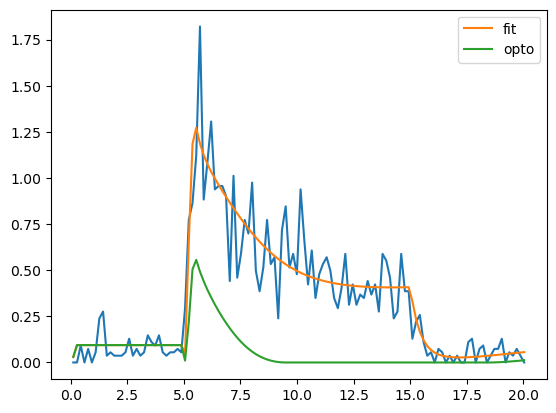

In [24]:
# Plot model against PC_subpopulation data and model prediction for optogenetics.

model = simulate_step(t_exp, init, params)
plt.plot(t_exp, data_pc_na)
plt.plot(t_exp, model["f_e_d"], label='fit')
plt.plot(t_exp, model["f_e_do"], label='opto')
plt.legend()

# Solve

## leastsq (Levenberg-Marquardt)

In [25]:
count = 0

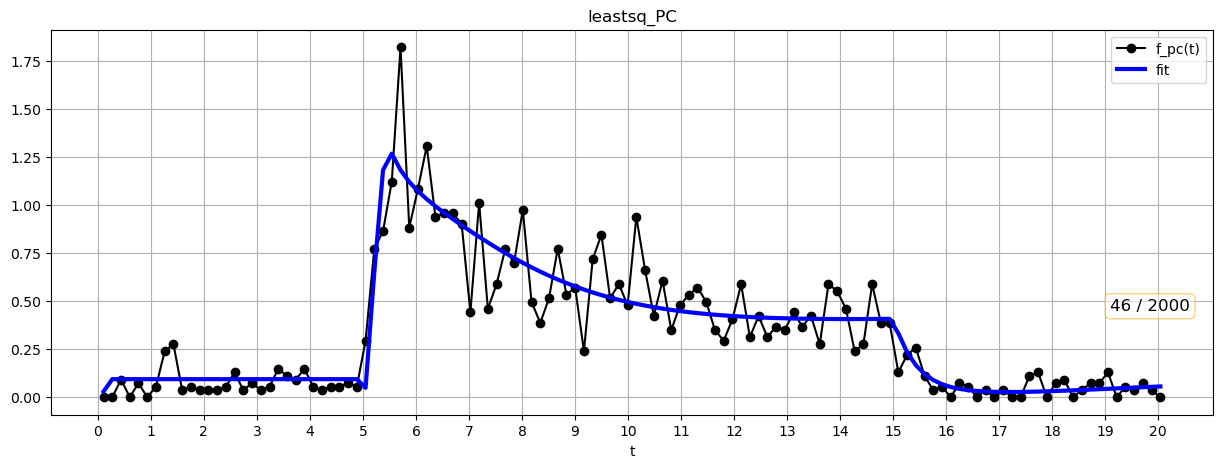


CPU times: total: 4min 12s
Wall time: 4min 15s


In [26]:
%%time
%matplotlib inline

result_leastsq = minimize(residual_ad, params, method='least_squares', args=(t_exp, init, data_pc_na), nan_policy='propagate', max_nfev=100, ftol=1e-15, gtol=1e-15, xtol=1e-15)
print()


In [27]:
report_fit(result_leastsq)

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 46
    # data points      = 122
    # variables        = 5
    chi-square         = 2.32355465
    reduced chi-square = 0.01985944
    Akaike info crit   = -473.232588
    Bayesian info crit = -459.212483
[[Variables]]
    w_0:        0.224948 (fixed)
    w_1:        1.101432 (fixed)
    w_2:        0.2481058 (fixed)
    w_3:        1.970023 (fixed)
    w_4:        0.3335787 (fixed)
    w_5:        0.523022 (fixed)
    w_6:        0.6009291 (fixed)
    w_7:        1.224994 (fixed)
    w_8:        1.488803 (fixed)
    w_9:        0.07577982 (fixed)
    w_10:       1.555514 (fixed)
    w_11:       0.3728128 (fixed)
    w_12:       0.185919 (fixed)
    w_13:       0.6969417 (fixed)
    w_14:       0.01562676 (fixed)
    w_15:       0.00630454 (fixed)
    w_16:       1.161046 (fixed)
    w_17:       0.4843349 (fixed)
    w_18:       9.1936e-05 (fixed)
    tau_0:      0.015 (fixed)
    tau_1:      0.0075 (fix

C:\Users\yk348\AppData\Local\anaconda3\Lib\site-packages\lmfit\printfuncs.py:187: RuntimeWarning: invalid value encountered in divide
  spercent = f'({abs(par.stderr/par.value):.2%})'


In [28]:
a_leastsq = RMSE(result_leastsq.params, init, data_pc_na, "f_e_d")
print(a_leastsq)

0.13829313001197036


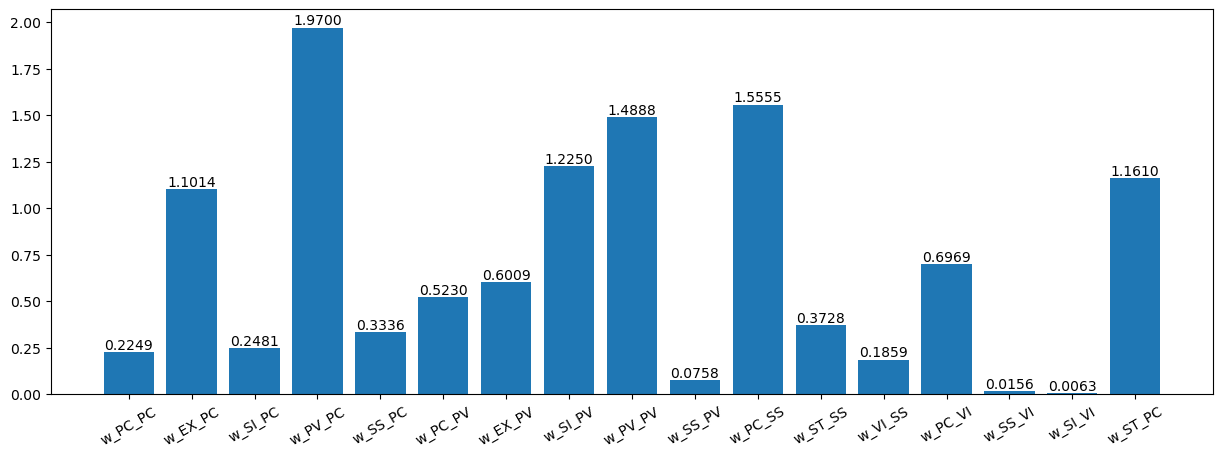

In [29]:
vals = []
for _, param in result_leastsq.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

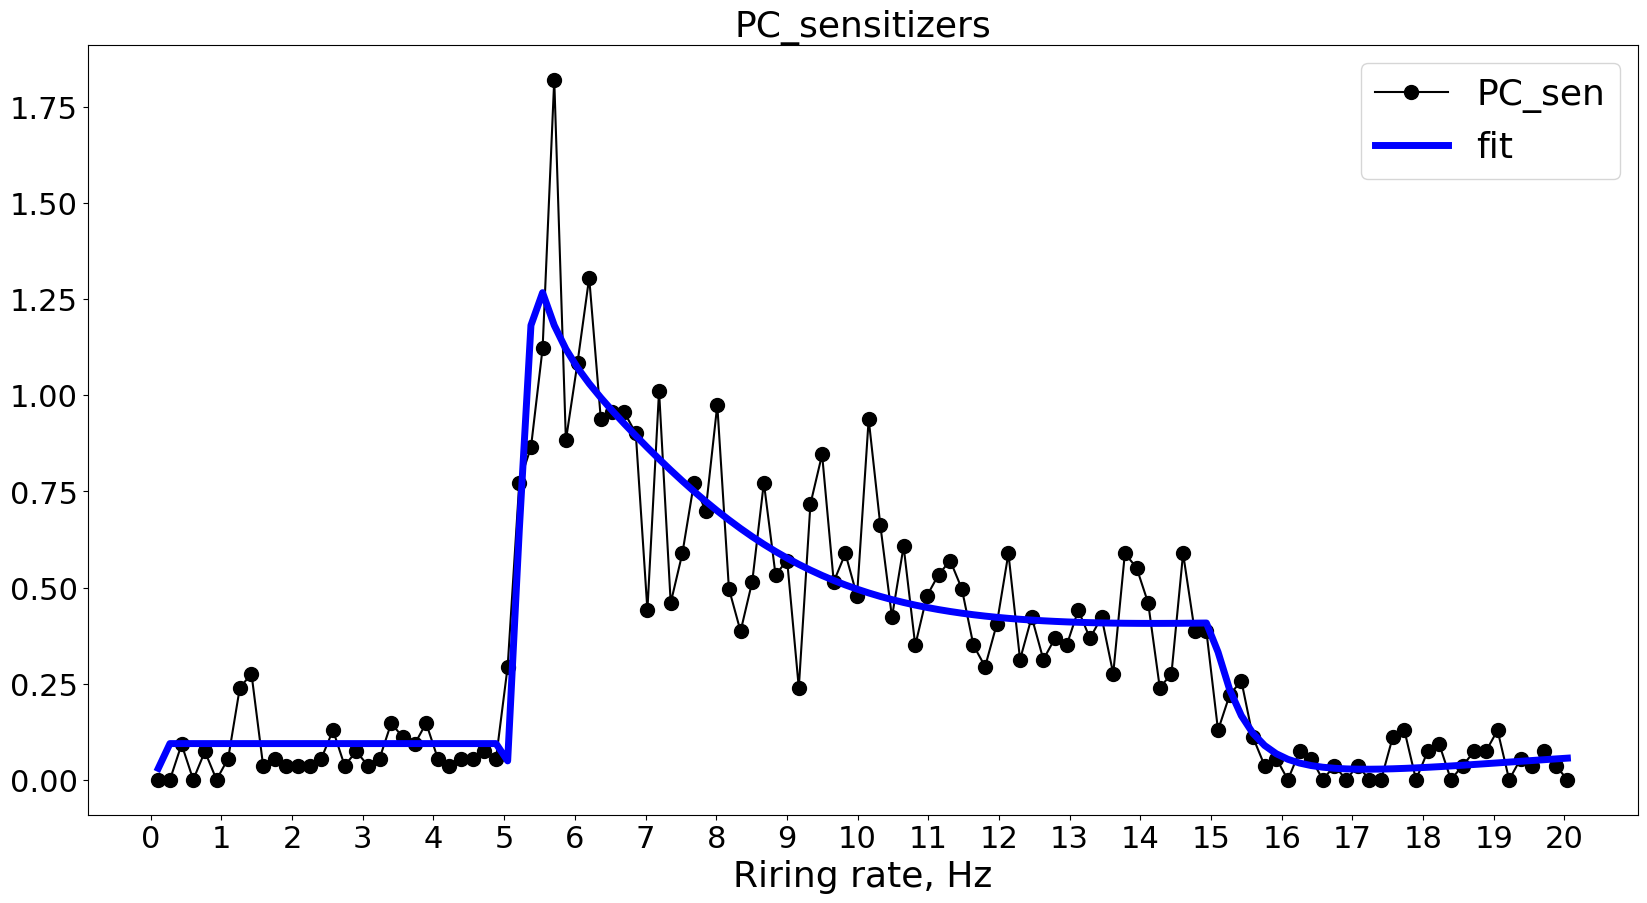

In [30]:
sim_leastsq = simulate_step(t_exp, init, params)
fit_leastsq = simulate_step(t_exp, init, result_leastsq.params)
    
plt.figure(figsize=(20,10))
plt.plot(t_exp, data_pc_na, color='black', marker='o', label='PC_sen', markersize = 10)
plt.plot(t_exp, fit_leastsq['f_e_d'].values, color='blue', label='fit', linewidth=5)

plt.title('PC_sensitizers', fontsize=26)
plt.legend(loc='best', fontsize=26)
plt.xlabel('time, t', fontsize=26)
plt.xlabel('Riring rate, Hz', fontsize=26)
#plt.ylim(0, 1.2)
plt.xticks(np.arange(0,21,1), size =22)
plt.yticks(size =22)
#plt.grid()
plt.show()

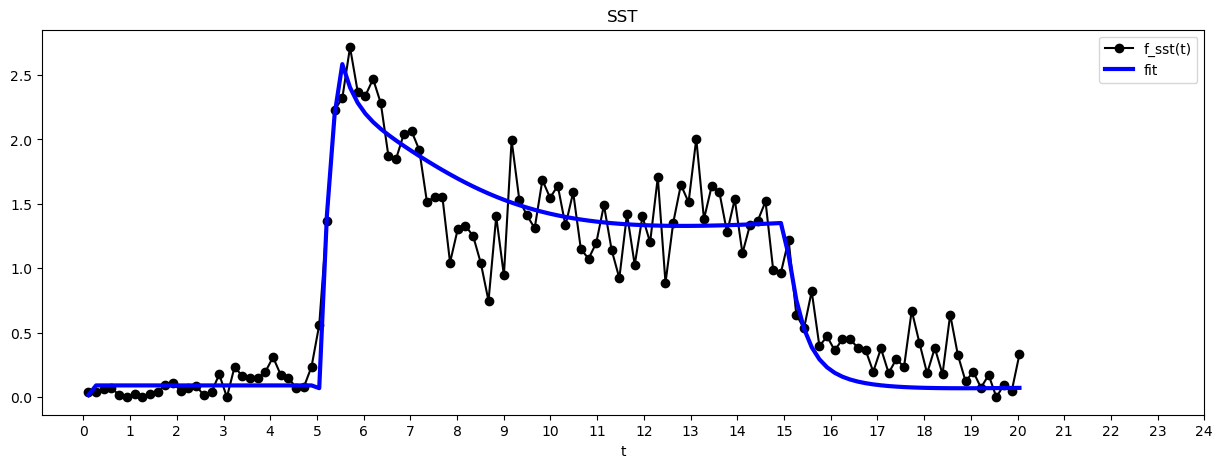

In [31]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_leastsq['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

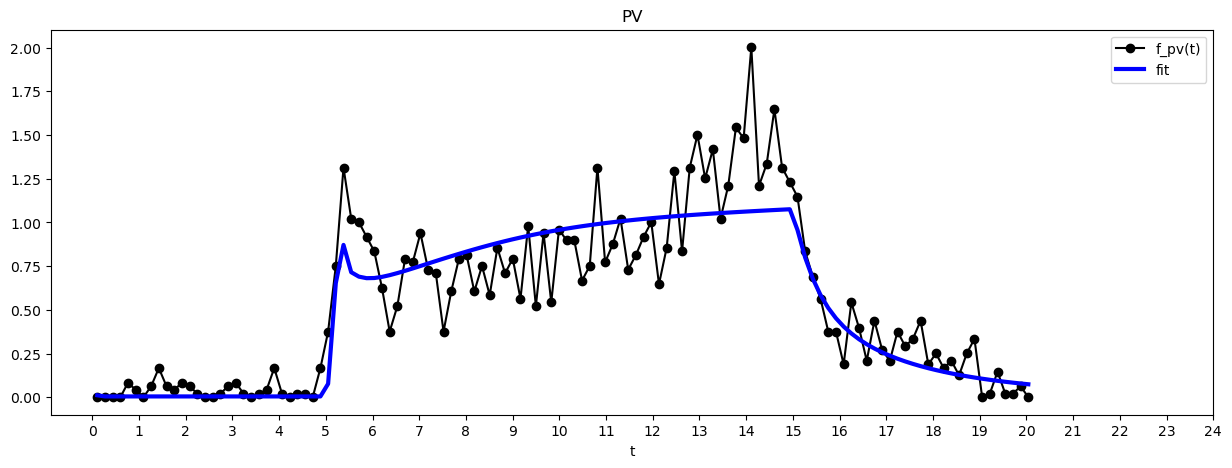

In [32]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_leastsq['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

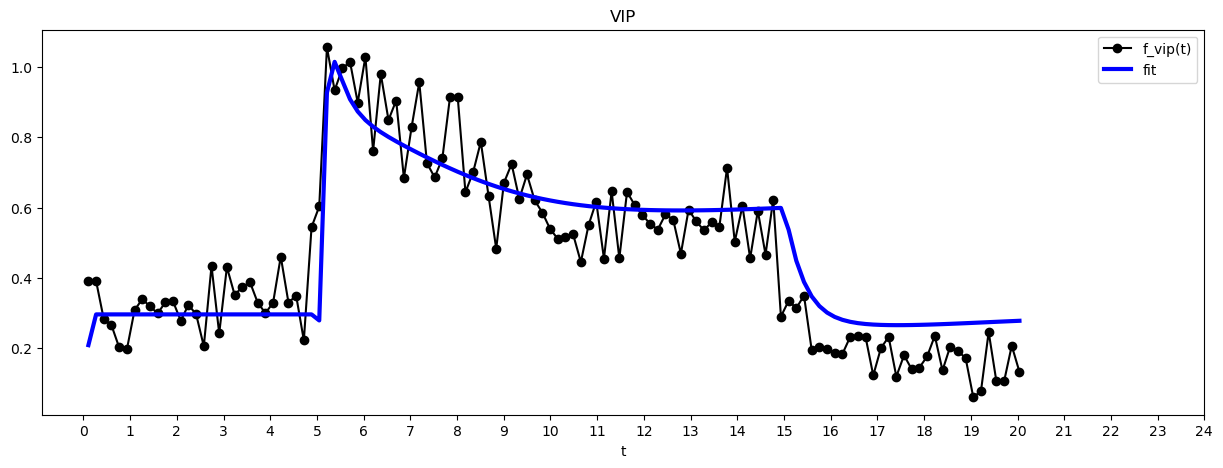

In [33]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_leastsq['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

In [34]:
model_opto = simulate_step(t_exp, init, result_leastsq.params)

In [35]:
#model_opto[['t', 'f_e_do']].to_csv('trace_C_s1_hab_NoLoco_NA_07_04_2025.csv', index=False)

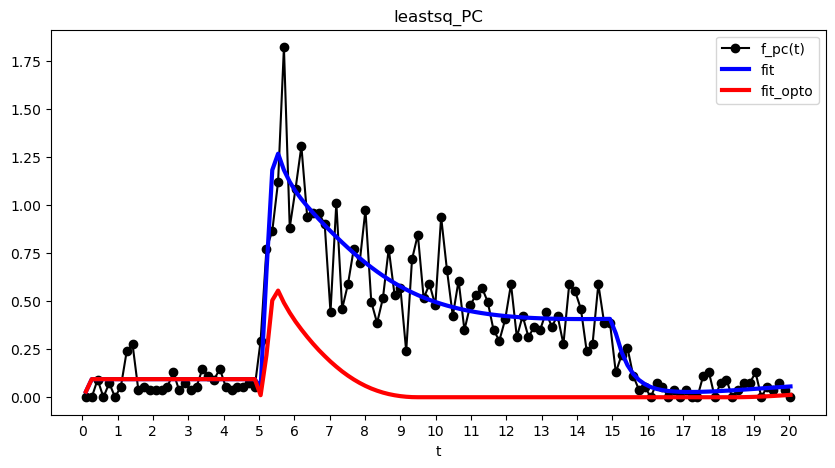

In [36]:
plt.figure(figsize=(10,5))
plt.plot(t_exp, data_pc_na, color='black', marker='o', label='f_pc(t)')

plt.plot(t_exp, model_opto['f_e_d'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_e_do'].values, color='red', label='fit_opto', linewidth=3)

plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.xlim(3,7)
#plt.grid()
plt.show()

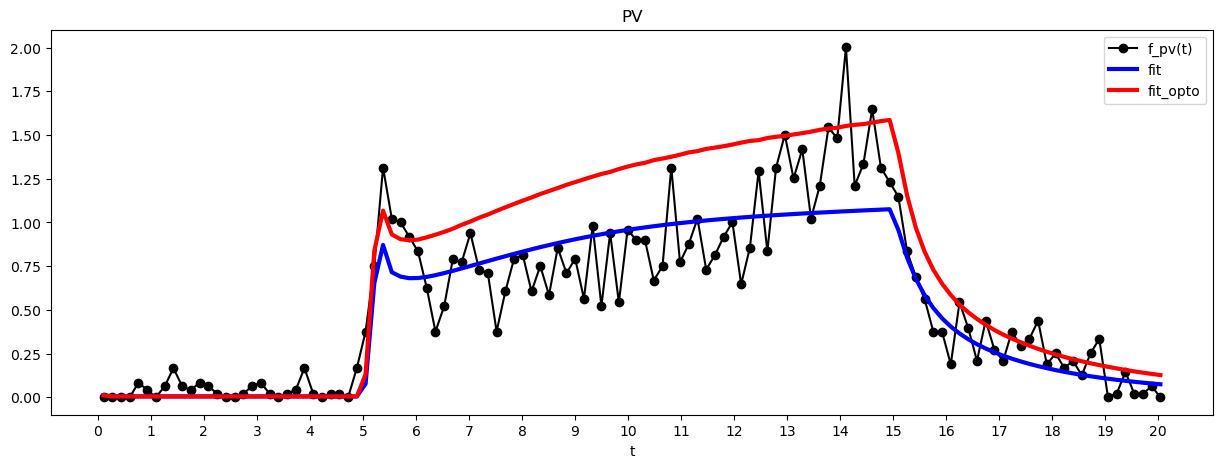

In [37]:
plt.figure(figsize=(15,5))


plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')

plt.plot(t_exp, model_opto['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

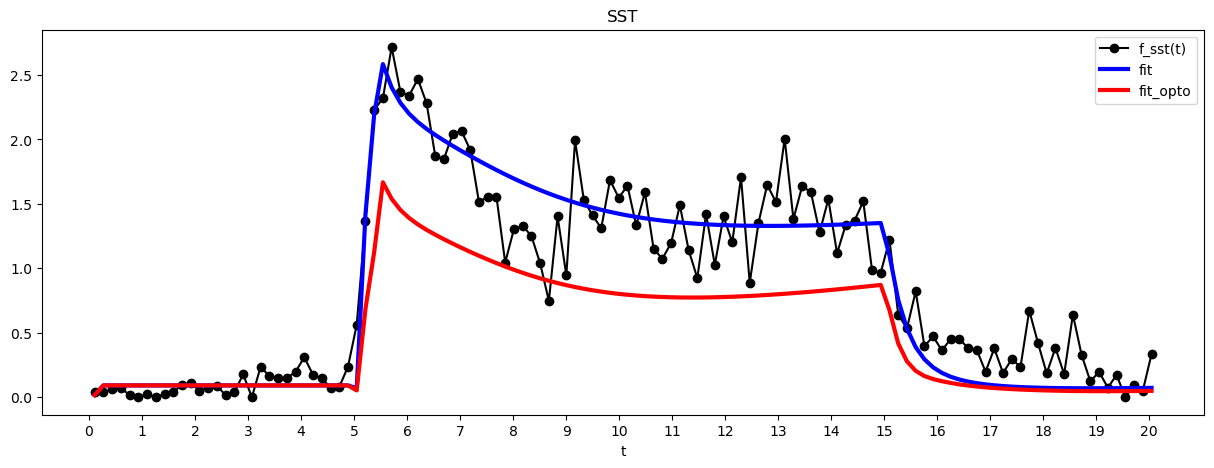

In [38]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model_opto['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

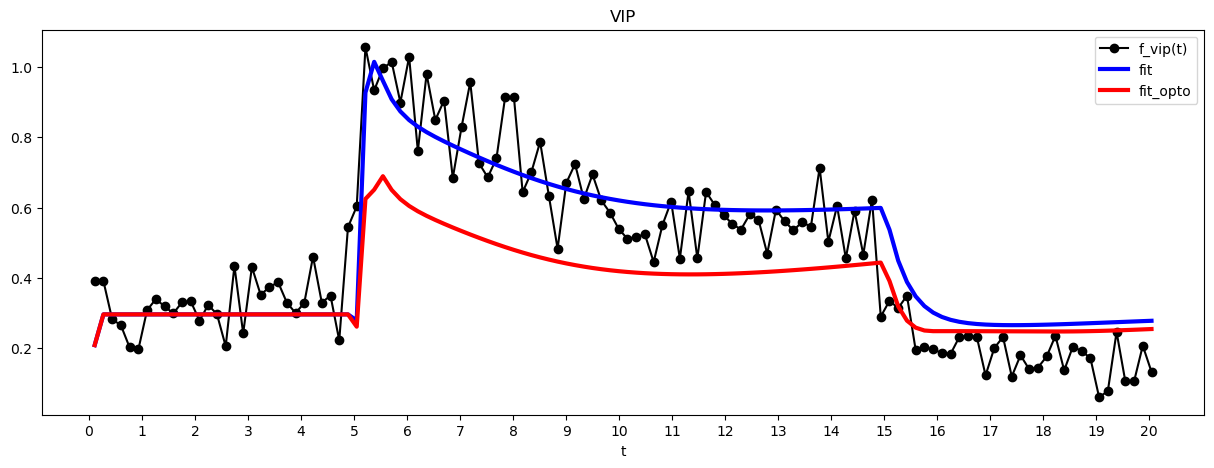

In [39]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model_opto['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [40]:
heat_old = pd.DataFrame()
heat_old[''] = ['PC', 'SST', 'PV', 'VIP_P']

heat_old['PC'] = [0.22494800,
                  1.55551425,
                  0.52302201,
                  0.69694172]

heat_old['SST'] = [0.33357873,
                  None,
                  0.07577982,
                  0.01562676]

heat_old['PV'] = [1.97002258,
                   None,
                   1.48880306,
                   None]

heat_old['VIP_P'] = [None,
                   0.18591899,
                   None,
                   None]

heat_old['FF'] = [1.10143194,
                   None,
                   0.60092909,
                   None]

heat_old['SM'] = [0.24810577,
                   None,
                   1.22499424,
                   0.00630454]

heat_old['FB'] = [1.16104597,
                   0.37281284,
                   0.48433493,
                   9.1936e-05]

heat_old.set_index('', inplace = True)

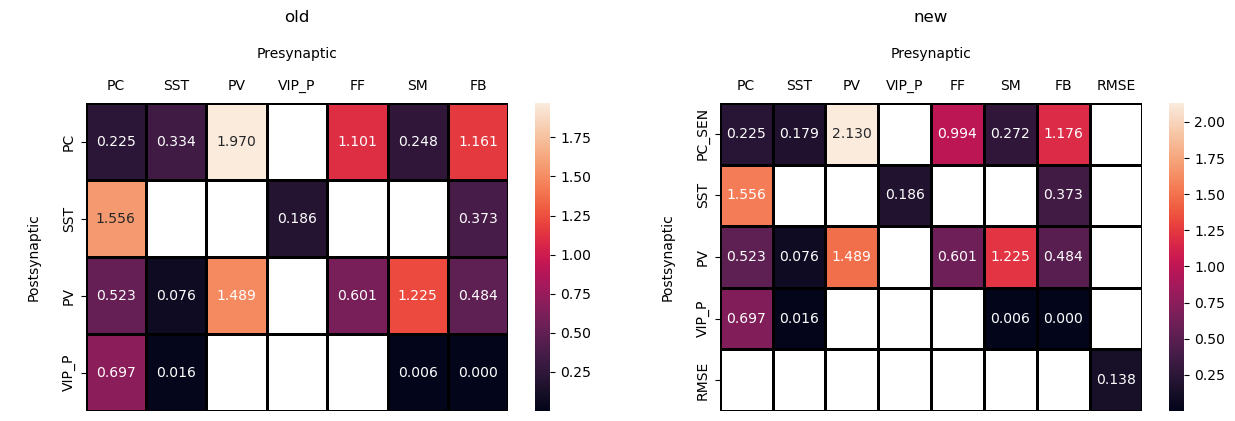

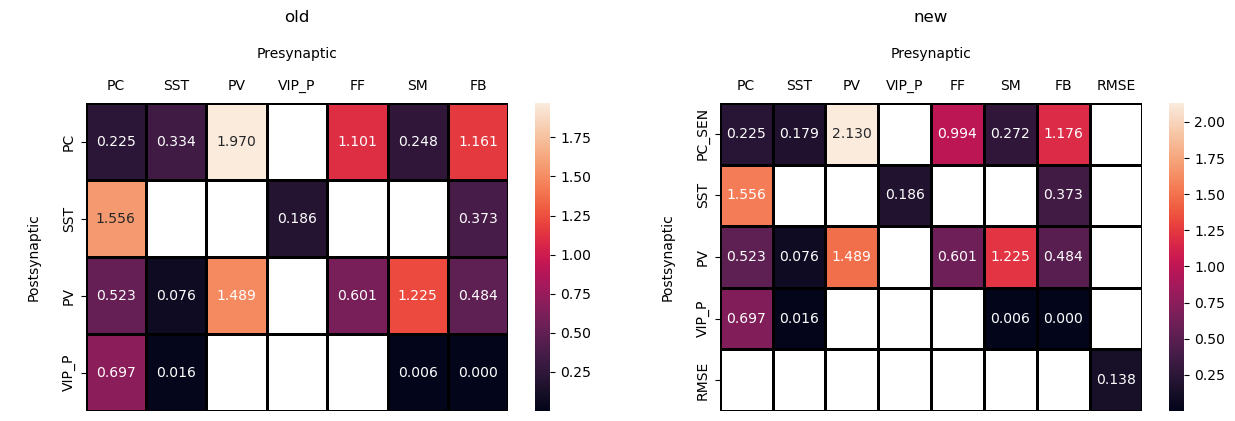

In [41]:
heat_new = pd.DataFrame()
heat_new[''] = ['PC_SEN', 'SST', 'PV', 'VIP_P', 'RMSE']

heat_new['PC'] = [result_leastsq.params["w_d_0"].value / scale,
                  1.55551425,
                  0.52302201,
                  0.69694172,
                  None]

heat_new['SST'] = [result_leastsq.params["w_d_5"].value / scale,
                  None,
                  0.07577982,
                  0.01562676,
                  None]

heat_new['PV'] = [result_leastsq.params["w_d_4"].value / scale,
                  None,
                   1.48880306,
                   None,
                   None]

heat_new['VIP_P'] = [None,
                   0.18591899,
                   None,
                   None,
                   None]


heat_new['FF'] = [result_leastsq.params["w_d_1"].value / scale,
                   None,
                   0.60092909,
                   None,
                   None]

heat_new['SM'] = [result_leastsq.params["w_d_2"].value / scale,
                   None,
                   1.22499424,
                   0.00630454,
                   None]

heat_new['FB'] = [result_leastsq.params["w_d_3"].value / scale,
                   0.37281284,
                   0.48433493,
                   9.1936e-05,
                   None]

heat_new['RMSE'] = [None,
                   None,
                   None,
                   None,
                   a_leastsq]

heat_new.set_index('', inplace = True)

heat_new = heat_new.map(lambda x: np.nan if x is None else x)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.heatmap(heat_old, ax=ax[0], annot = True, linewidth = 1, linecolor = 'black', fmt=".3f")
sns.heatmap(heat_new, ax=ax[1], annot = True, linewidth = 1, linecolor = 'black', fmt=".3f")
ax[0].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[0].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[0].title.set_text("old")
ax[0].xaxis.set_label_position("top")
ax[1].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[1].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[1].title.set_text("new")
ax[1].xaxis.set_label_position("top")
display.display(fig)

In [42]:
heat_new_ = pd.DataFrame()
heat_new_[''] = ['PC_NA', 'SST', 'PV', 'VIP_P']

heat_new_['PC'] = [result_leastsq.params["w_d_0"].value,
                  0.78370724,
                  0.20723919,
                  0.32398988]

heat_new_['SST'] = [result_leastsq.params["w_d_5"].value,
                  None,
                  0.25013329,
                  0.19112577]

heat_new_['PV'] = [result_leastsq.params["w_d_4"].value,
                   None,
                   1.51029559,
                   None]

heat_new_['VIP_P'] = [None,
                   0.14997032,
                   None,
                   None]

heat_new_['FF'] = [result_leastsq.params["w_d_1"].value,
                   None,
                   0.92636845,
                   None]

heat_new_['SM'] = [result_leastsq.params["w_d_2"].value,
                   None,
                   2.11169434,
                   0.73762300]

heat_new_['FB'] = [result_leastsq.params["w_d_3"].value,
                   0.59415933,
                   0.17580747,
                   0.15806817]

heat_new_.set_index('', inplace = True)

In [43]:
heat_old = heat_old.map(lambda x: np.nan if x is None else x)
heat_new = heat_new.map(lambda x: np.nan if x is None else x)
heat_new_ = heat_new_.map(lambda x: np.nan if x is None else x)

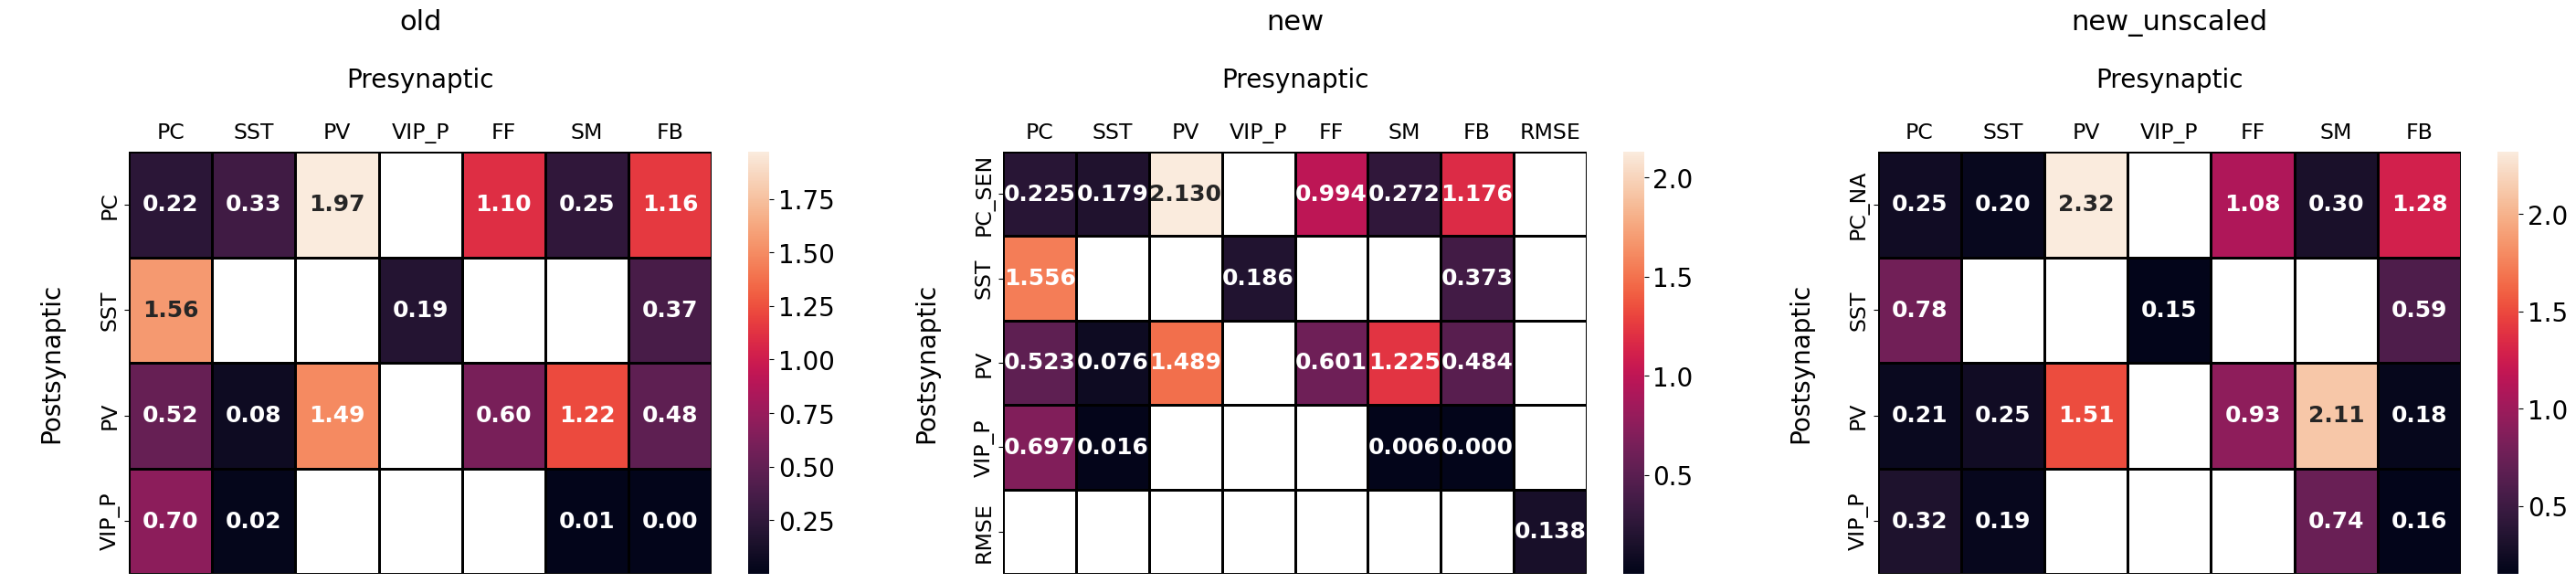

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(35, 6))
sns.heatmap(heat_old, ax=ax[0], annot = True, linewidth = 1, linecolor = 'black', fmt=".2f", annot_kws = {"size" : 18, "weight" : 800})
sns.heatmap(heat_new, ax=ax[1], annot = True, linewidth = 1, linecolor = 'black', fmt=".3f", annot_kws = {"size" : 18, "weight" : 800})
sns.heatmap(heat_new_, ax=ax[2], annot = True, linewidth = 1, linecolor = 'black', fmt=".2f", annot_kws = {"size" : 18, "weight" : 800})
ax[0].tick_params(axis='both', which='major', labelsize=17, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[0].set_xlabel("\nPresynaptic\n", fontdict={"fontsize" : 20}) 
ax[0].set_ylabel("\nPostsynaptic\n", fontdict={"fontsize" : 20})
ax[0].set_title("old", fontdict={"fontsize" : 22})
ax[0].xaxis.set_label_position("top")
cbar = ax[0].collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=17, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[1].set_xlabel("\nPresynaptic\n", fontdict={"fontsize" : 20}) 
ax[1].set_ylabel("\nPostsynaptic\n", fontdict={"fontsize" : 20})
ax[1].set_title("new", fontdict={"fontsize" : 22})
ax[1].xaxis.set_label_position("top")
cbar = ax[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
ax[2].tick_params(axis='both', which='major', labelsize=17, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[2].set_xlabel("\nPresynaptic\n", fontdict={"fontsize" : 20}) 
ax[2].set_ylabel("\nPostsynaptic\n", fontdict={"fontsize" : 20})
ax[2].set_title("new_unscaled", fontdict={"fontsize" : 22})
ax[2].xaxis.set_label_position("top")
cbar = ax[2].collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
#display.display(fig)

In [45]:
#heat_new.to_csv("heatmap_C_s1_hab_NoLoco_NA_07_04_2025.csv")

## least_squares

In [46]:
count = 0

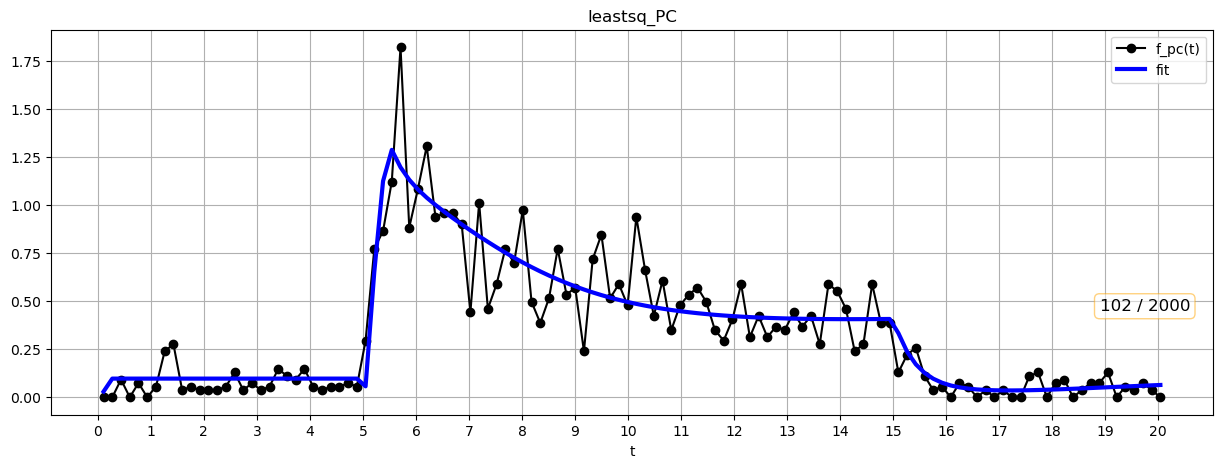


CPU times: total: 9min 2s
Wall time: 9min 5s


In [47]:
%%time
%matplotlib inline

result_leastsqs = minimize(residual_ad, params, method='leastsq', args=(t_exp, init, data_pc_na), nan_policy='propagate', max_nfev=100, ftol=1e-15, gtol=1e-15, xtol=1e-15)
print()


In [48]:
report_fit(result_leastsqs)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 122
    # variables        = 5
    chi-square         = 2.28348008
    reduced chi-square = 0.01951692
    Akaike info crit   = -475.355091
    Bayesian info crit = -461.334986
##  Warning: uncertainties could not be estimated:
[[Variables]]
    w_0:        0.224948 (fixed)
    w_1:        1.101432 (fixed)
    w_2:        0.2481058 (fixed)
    w_3:        1.970023 (fixed)
    w_4:        0.3335787 (fixed)
    w_5:        0.523022 (fixed)
    w_6:        0.6009291 (fixed)
    w_7:        1.224994 (fixed)
    w_8:        1.488803 (fixed)
    w_9:        0.07577982 (fixed)
    w_10:       1.555514 (fixed)
    w_11:       0.3728128 (fixed)
    w_12:       0.185919 (fixed)
    w_13:       0.6969417 (fixed)
    w_14:       0.01562676 (fixed)
    w_15:       0.00630454 (fixed)
    w_16:       1.161046 (fixed)
    w_17:       0.4843349 (fixed)
    w_18:       9.1936e-05 (fixed)
    tau_0: 

In [49]:
a_leastsqs = RMSE(result_leastsqs.params, init, data_pc_na, "f_e_d")
print(a_leastsqs)

0.1371415187111965


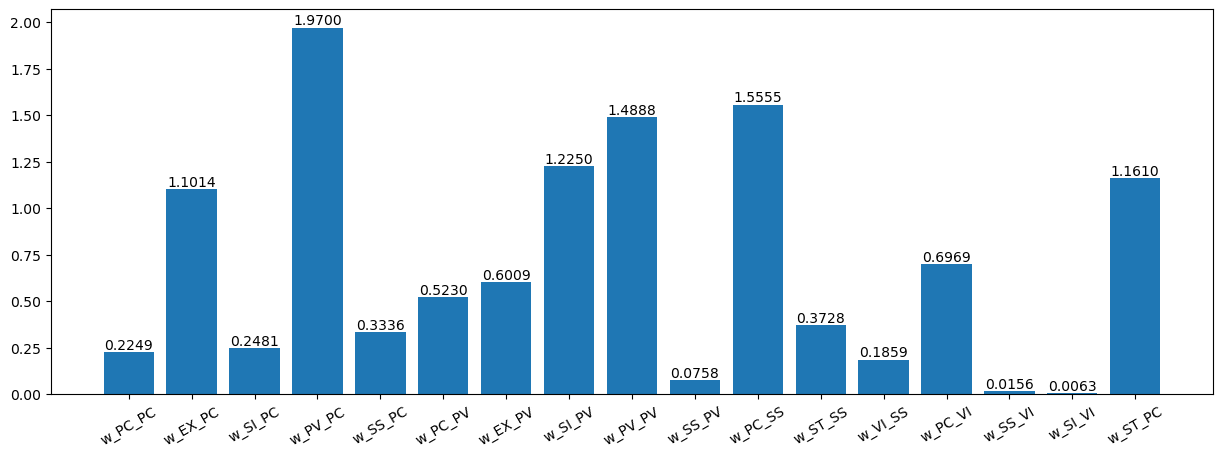

In [50]:
vals = []
for _, param in result_leastsqs.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

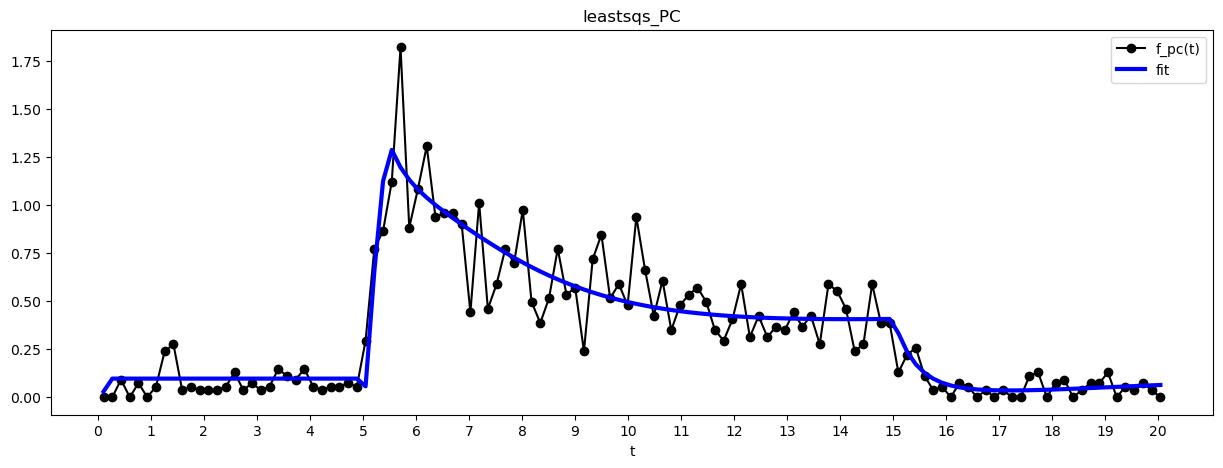

In [51]:
sim_leastsqs = simulate_step(t_exp, init, params)
fit_leastsqs = simulate_step(t_exp, init, result_leastsqs.params)
    
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pc_na, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_leastsqs['f_e_d'].values, color='blue', label='fit', linewidth=3)

plt.title('leastsqs_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

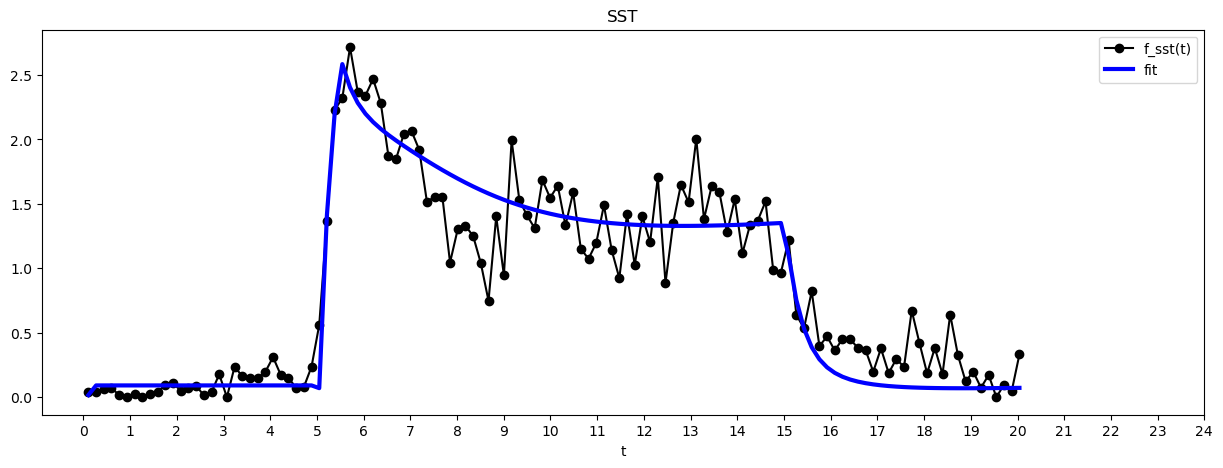

In [52]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_leastsqs['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

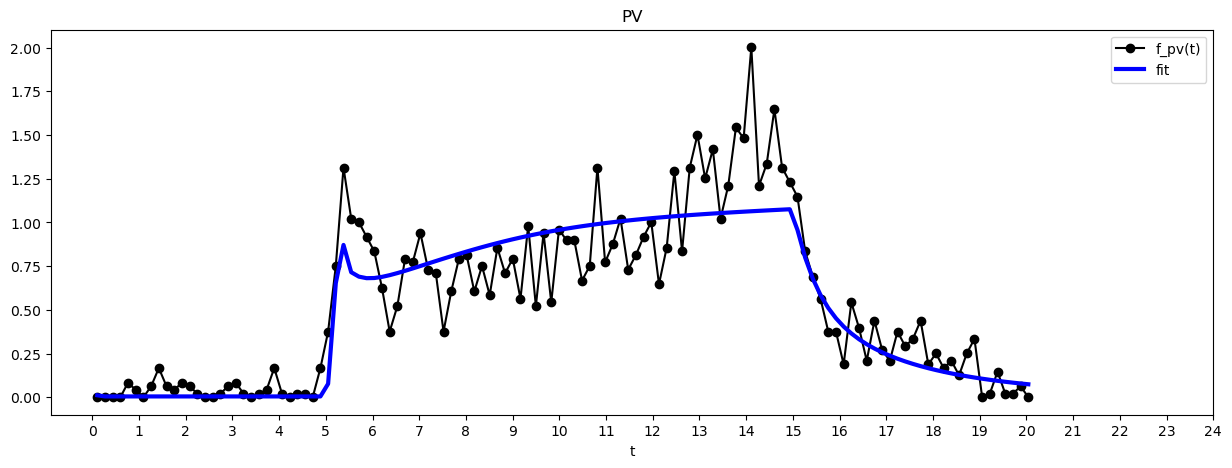

In [53]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_leastsqs['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

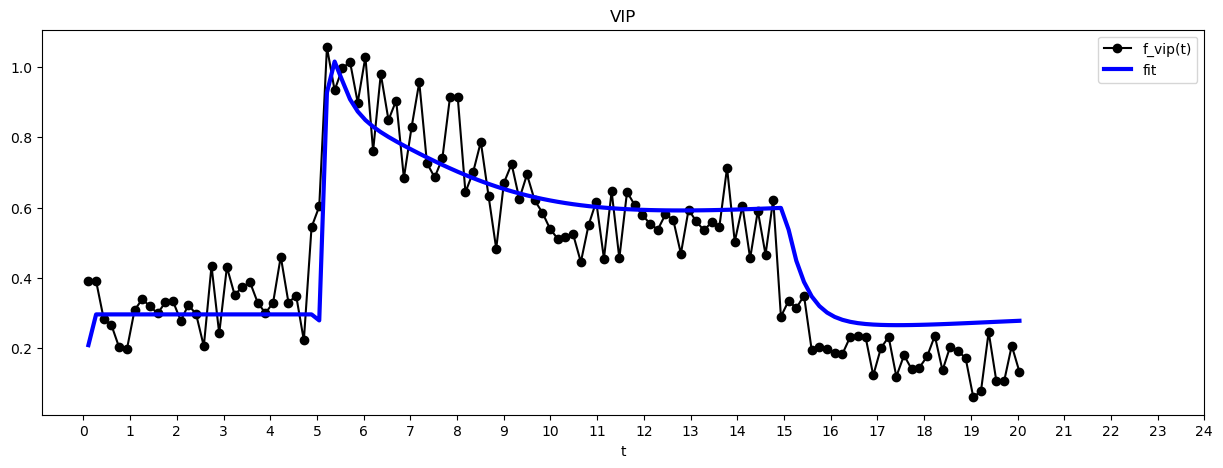

In [54]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_leastsqs['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

In [55]:
model_opto = simulate_step(t_exp, init, result_leastsqs.params)

In [56]:
#model_opto[['t', 'f_e_do']].to_csv('trace_s1_hab_Loco_NA_27_03_2025.csv', index=False)

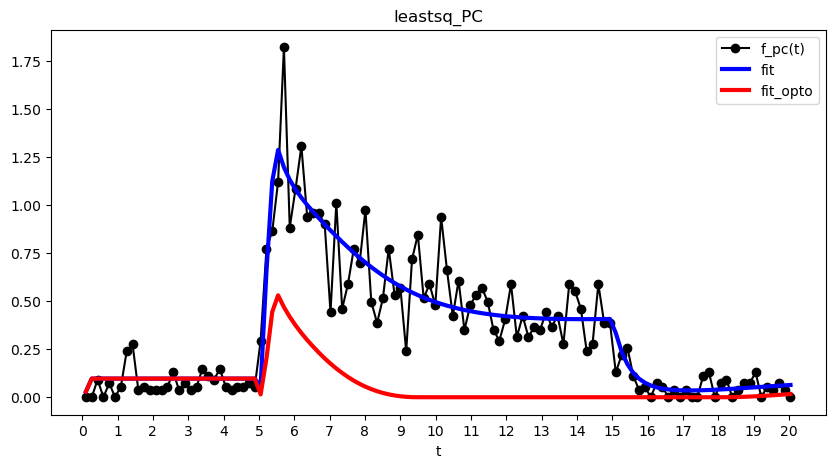

In [57]:
plt.figure(figsize=(10,5))
plt.plot(t_exp, data_pc_na, color='black', marker='o', label='f_pc(t)')

plt.plot(t_exp, model_opto['f_e_d'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_e_do'].values, color='red', label='fit_opto', linewidth=3)

plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.xlim(3,7)
#plt.grid()
plt.show()

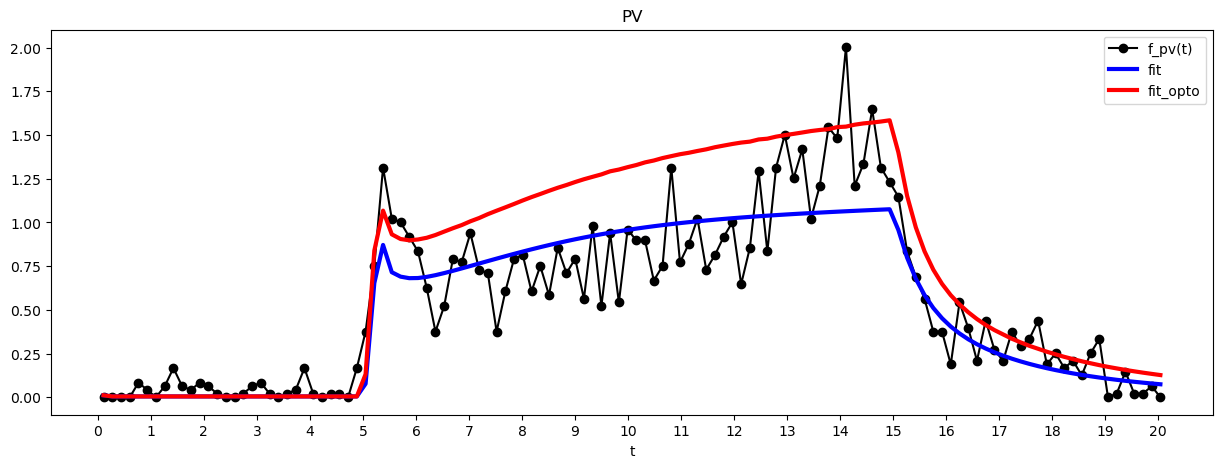

In [58]:
plt.figure(figsize=(15,5))


plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')

plt.plot(t_exp, model_opto['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

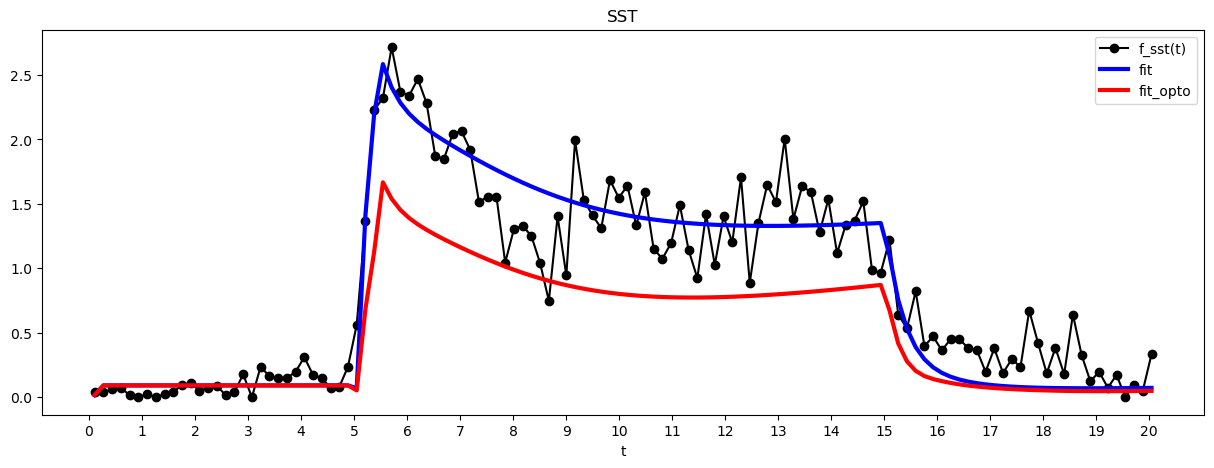

In [59]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model_opto['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

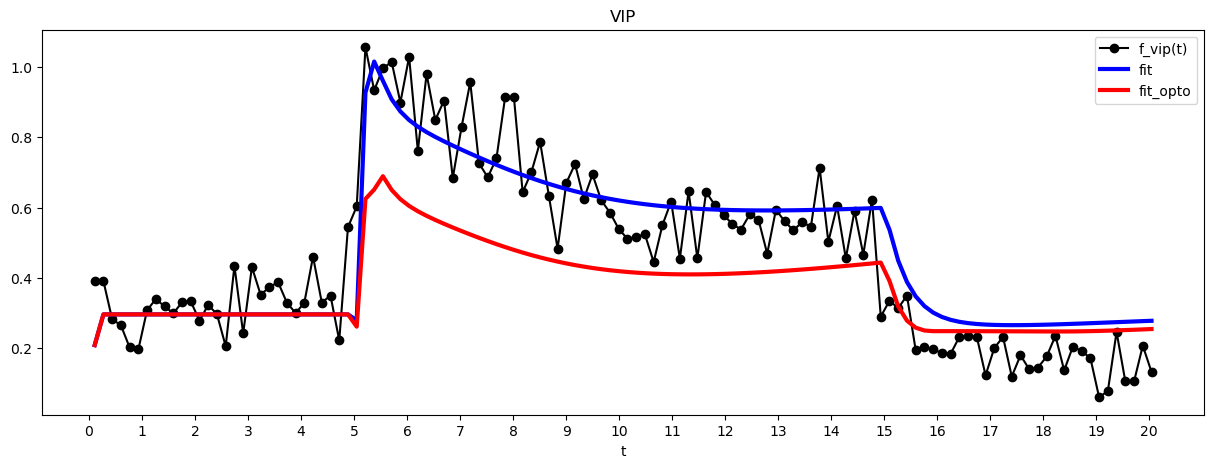

In [60]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model_opto['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

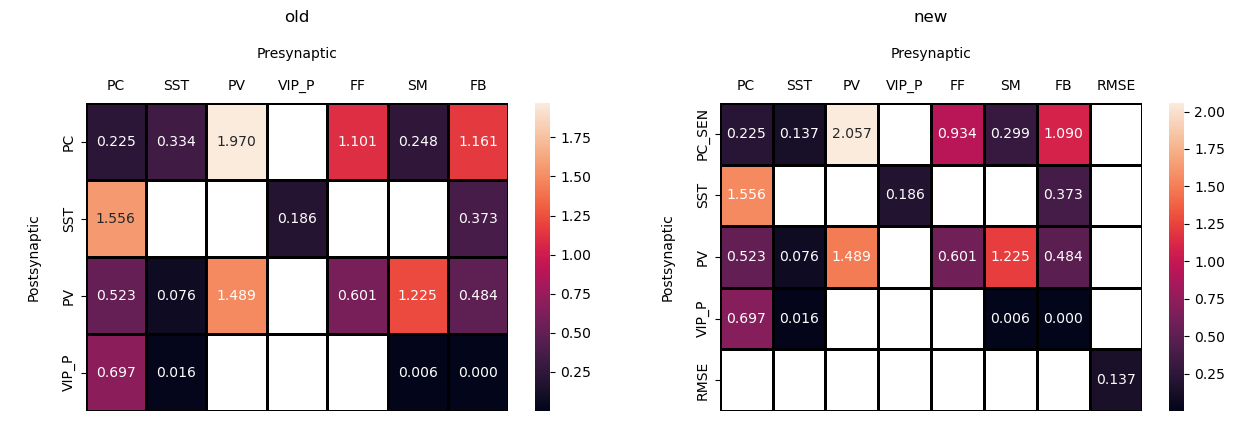

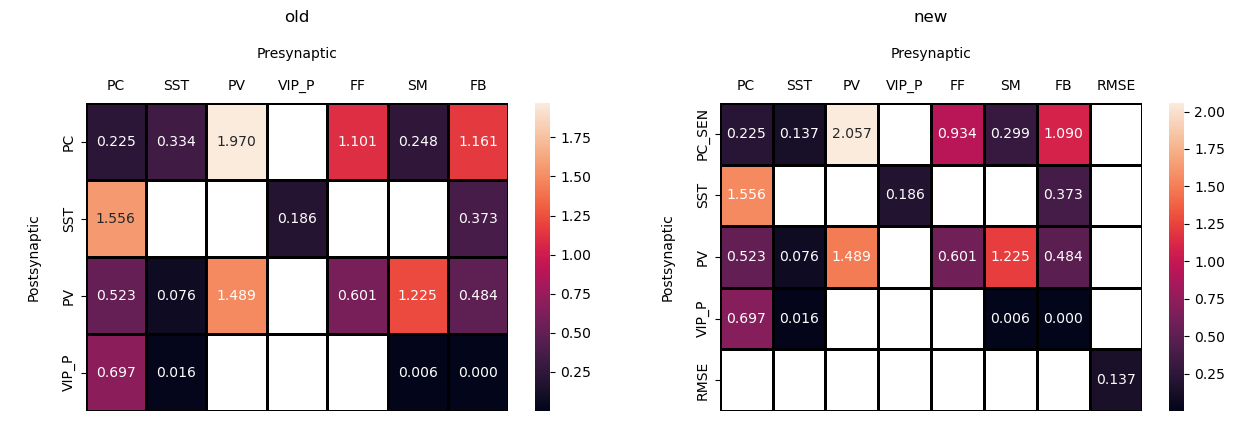

In [61]:
heat_new = pd.DataFrame()
heat_new[''] = ['PC_SEN', 'SST', 'PV', 'VIP_P', 'RMSE']

heat_new['PC'] = [result_leastsqs.params["w_d_0"].value / scale,
                  1.55551425,
                  0.52302201,
                  0.69694172,
                  None]

heat_new['SST'] = [result_leastsqs.params["w_d_5"].value / scale,
                  None,
                  0.07577982,
                  0.01562676,
                  None]

heat_new['PV'] = [result_leastsqs.params["w_d_4"].value / scale,
                  None,
                   1.48880306,
                   None,
                   None]

heat_new['VIP_P'] = [None,
                   0.18591899,
                   None,
                   None,
                   None]


heat_new['FF'] = [result_leastsqs.params["w_d_1"].value / scale,
                   None,
                   0.60092909,
                   None,
                   None]

heat_new['SM'] = [result_leastsqs.params["w_d_2"].value / scale,
                   None,
                   1.22499424,
                   0.00630454,
                   None]

heat_new['FB'] = [result_leastsqs.params["w_d_3"].value / scale,
                   0.37281284,
                   0.48433493,
                   9.1936e-05,
                   None]

heat_new['RMSE'] = [None,
                   None,
                   None,
                   None,
                   a_leastsqs]

heat_new.set_index('', inplace = True)

heat_new = heat_new.map(lambda x: np.nan if x is None else x)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.heatmap(heat_old, ax=ax[0], annot = True, linewidth = 1, linecolor = 'black', fmt=".3f")
sns.heatmap(heat_new, ax=ax[1], annot = True, linewidth = 1, linecolor = 'black', fmt=".3f")
ax[0].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[0].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[0].title.set_text("old")
ax[0].xaxis.set_label_position("top")
ax[1].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[1].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[1].title.set_text("new")
ax[1].xaxis.set_label_position("top")
display.display(fig)

In [62]:
#heat_new.to_csv("heatmap_s1_hab_Loco_NA_27_03_2025.csv")

## nelder

In [63]:
count = 0

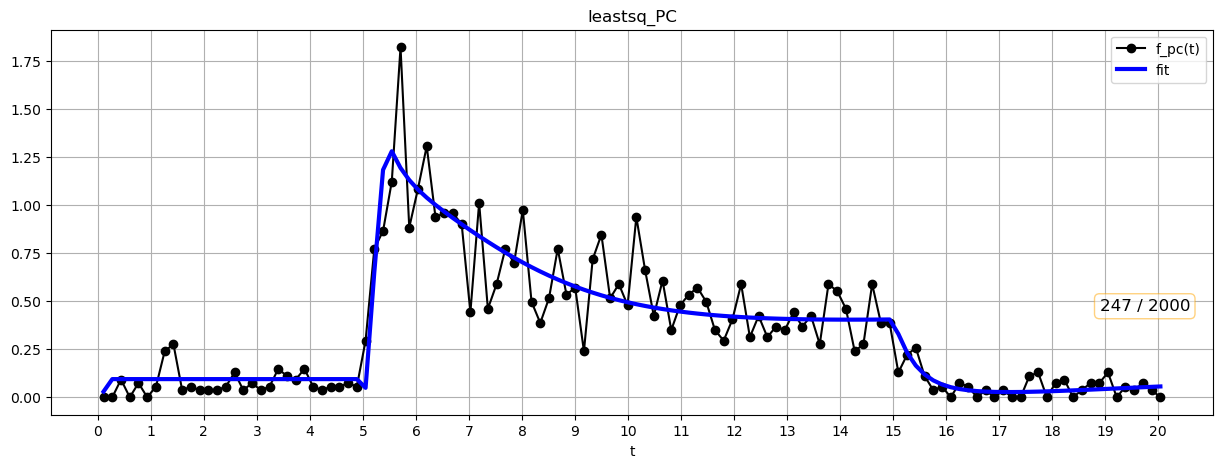


CPU times: total: 20min 41s
Wall time: 20min 47s


In [64]:
%%time

%matplotlib inline

result_nelder = minimize(residual_ad, params, method='nelder', args=(t_exp, init, data_pc_na), nan_policy='propagate', options = {'adaptive' : True}, max_nfev = 1500)
print()


In [65]:
report_fit(result_nelder)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 196
    # data points      = 122
    # variables        = 5
    chi-square         = 2.32195487
    reduced chi-square = 0.01984577
    Akaike info crit   = -473.316615
    Bayesian info crit = -459.296510
##  Warning: uncertainties could not be estimated:
[[Variables]]
    w_0:        0.224948 (fixed)
    w_1:        1.101432 (fixed)
    w_2:        0.2481058 (fixed)
    w_3:        1.970023 (fixed)
    w_4:        0.3335787 (fixed)
    w_5:        0.523022 (fixed)
    w_6:        0.6009291 (fixed)
    w_7:        1.224994 (fixed)
    w_8:        1.488803 (fixed)
    w_9:        0.07577982 (fixed)
    w_10:       1.555514 (fixed)
    w_11:       0.3728128 (fixed)
    w_12:       0.185919 (fixed)
    w_13:       0.6969417 (fixed)
    w_14:       0.01562676 (fixed)
    w_15:       0.00630454 (fixed)
    w_16:       1.161046 (fixed)
    w_17:       0.4843349 (fixed)
    w_18:       9.1936e-05 (fixed)
    tau

In [66]:
a_nelder = RMSE(result_nelder.params, init, data_pc_na, "f_e_d")
print(a_nelder)

0.13824885198801437


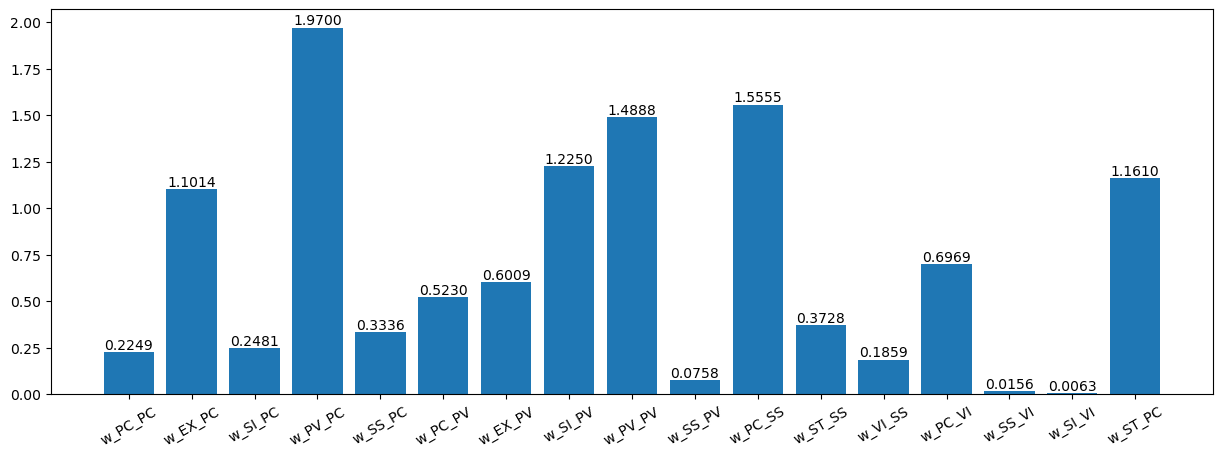

In [67]:
vals = []
for _, param in result_nelder.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

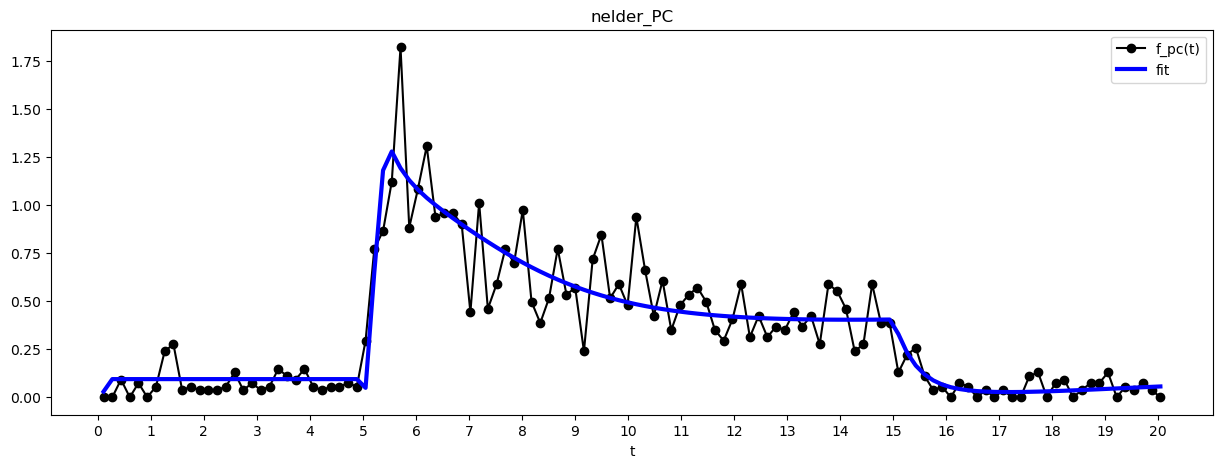

In [68]:
sim_nelder = simulate_step(t_exp, init, params)
fit_nelder = simulate_step(t_exp, init, result_nelder.params)


plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pc_na, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_nelder['f_e_d'].values, color='blue', label='fit', linewidth=3)

plt.title('nelder_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 5)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

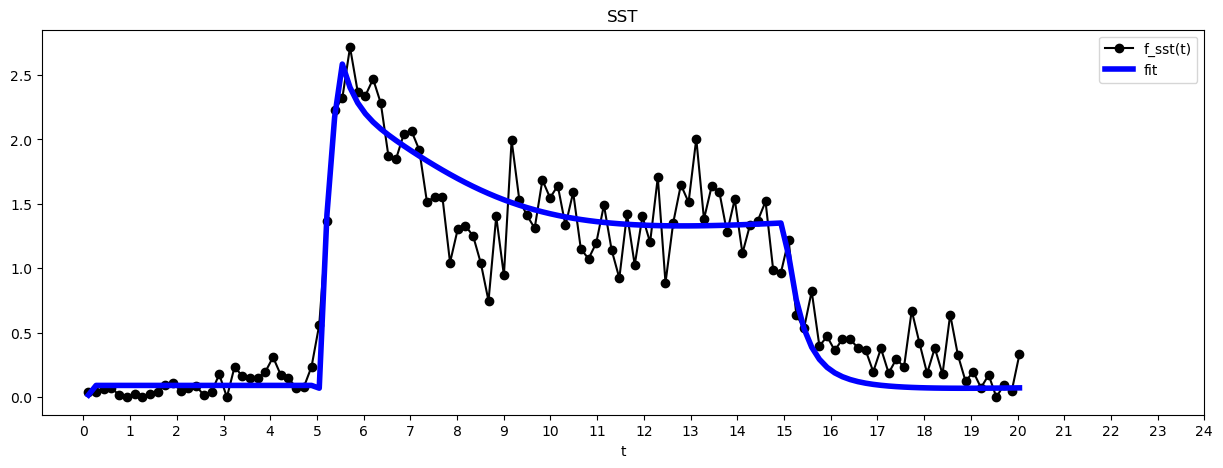

In [69]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_nelder['f_sst'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.ylim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

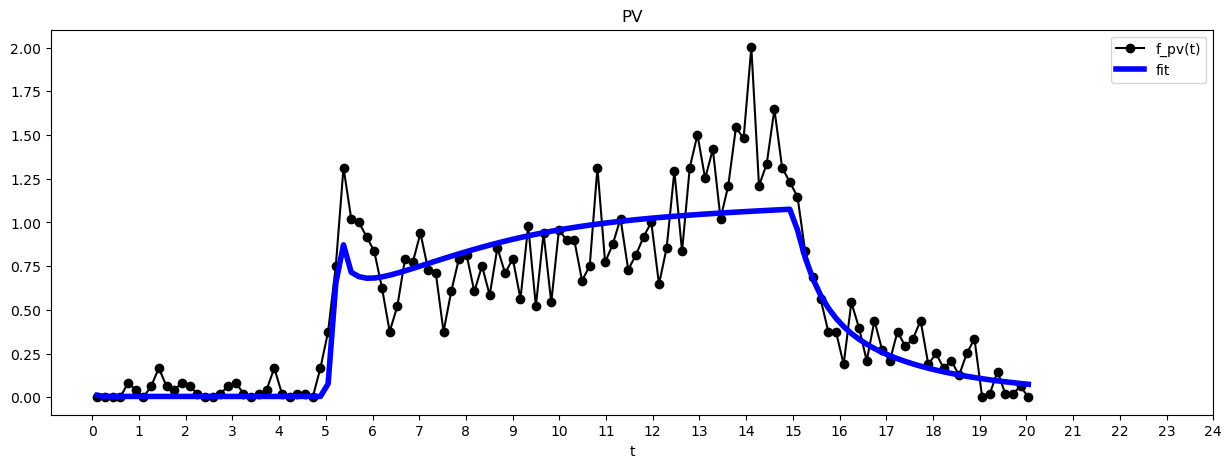

In [70]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_nelder['f_pv'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

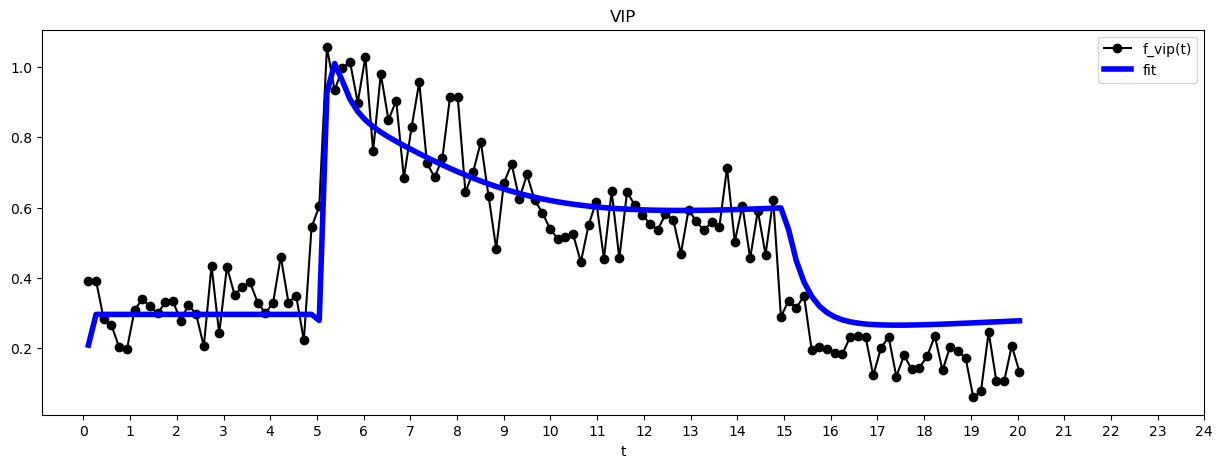

In [71]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_nelder['f_vip'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

In [72]:
model_opto = simulate_step(t_exp, init, result_nelder.params)

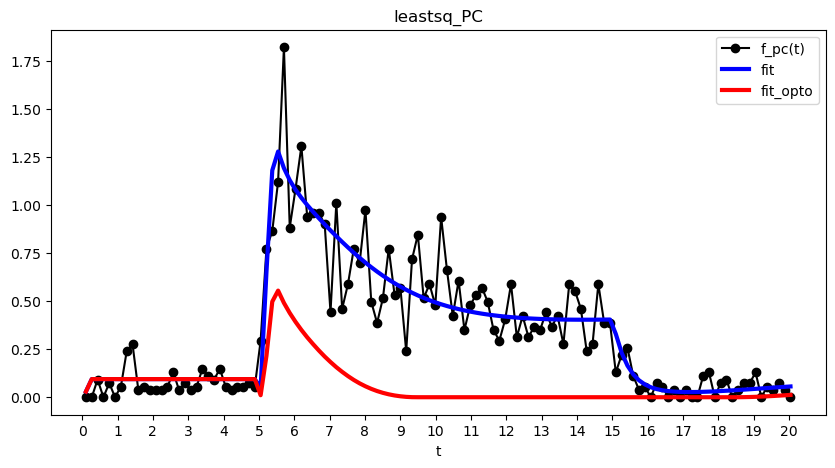

In [73]:
plt.figure(figsize=(10,5))
plt.plot(t_exp, data_pc_na, color='black', marker='o', label='f_pc(t)')

plt.plot(t_exp, model_opto['f_e_d'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_e_do'].values, color='red', label='fit_opto', linewidth=3)

plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.xlim(3,7)
#plt.grid()
plt.show()

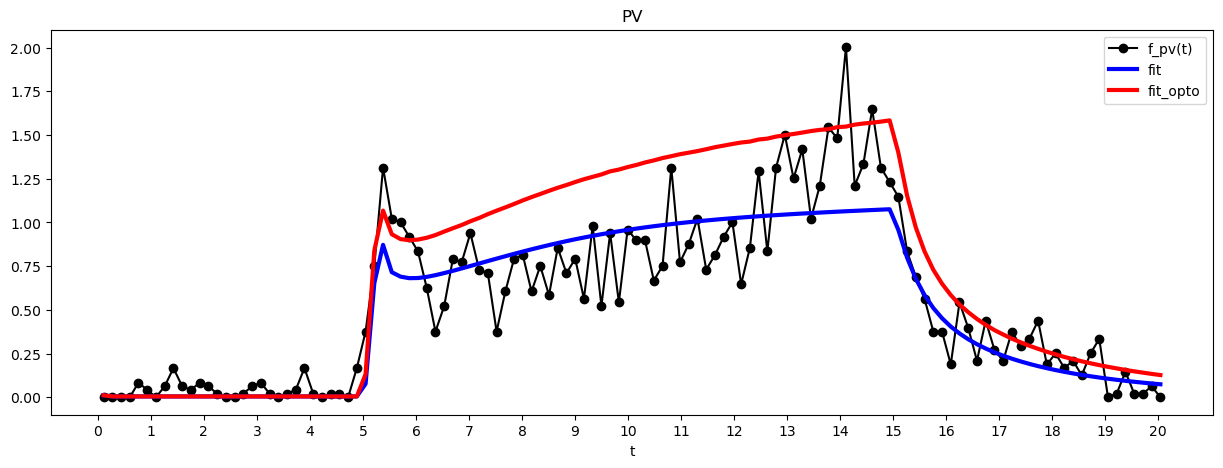

In [74]:
plt.figure(figsize=(15,5))


plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')

plt.plot(t_exp, model_opto['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

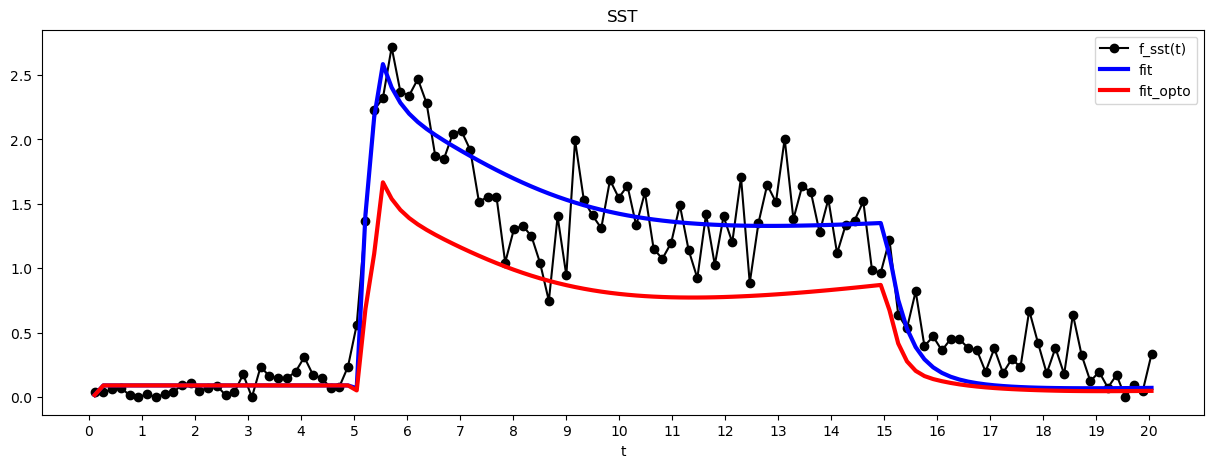

In [75]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model_opto['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

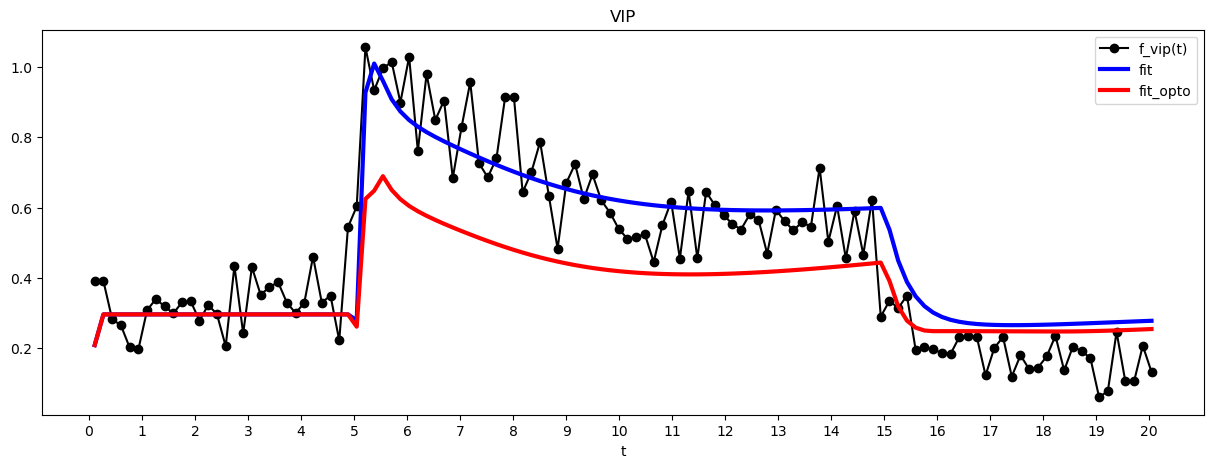

In [76]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model_opto['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

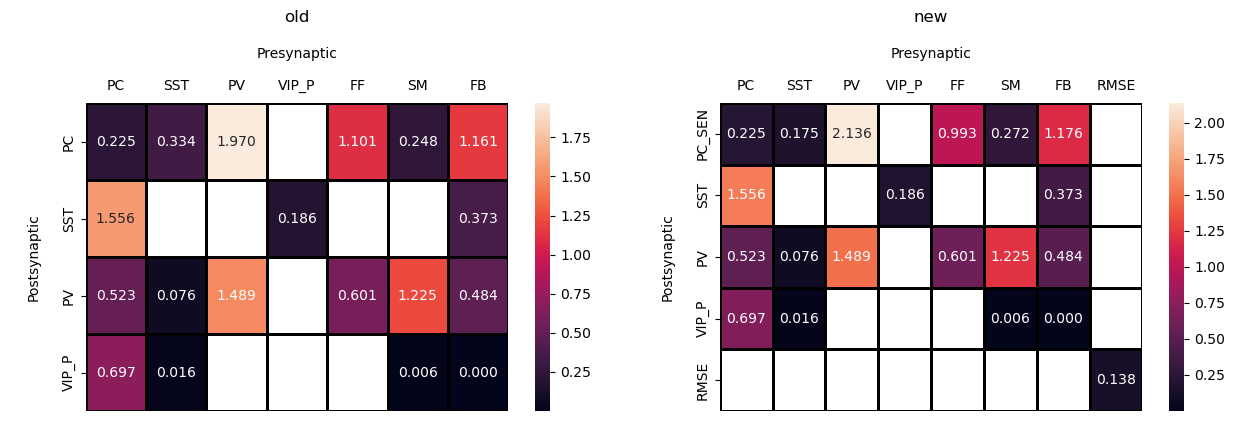

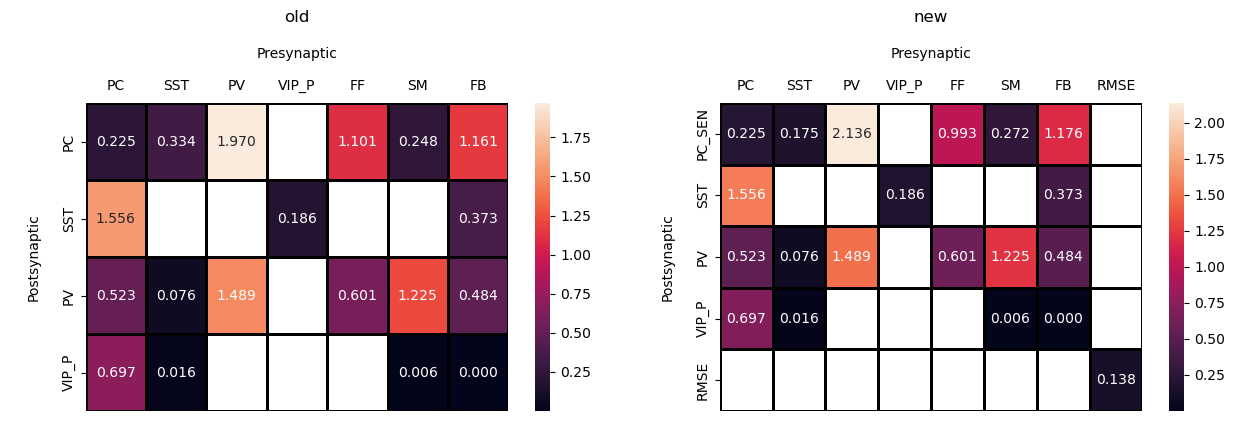

In [77]:
heat_new = pd.DataFrame()
heat_new[''] = ['PC_SEN', 'SST', 'PV', 'VIP_P', 'RMSE']

heat_new['PC'] = [result_nelder.params["w_d_0"].value / scale,
                  1.55551425,
                  0.52302201,
                  0.69694172,
                  None]

heat_new['SST'] = [result_nelder.params["w_d_5"].value / scale,
                  None,
                  0.07577982,
                  0.01562676,
                  None]

heat_new['PV'] = [result_nelder.params["w_d_4"].value / scale,
                  None,
                   1.48880306,
                   None,
                   None]

heat_new['VIP_P'] = [None,
                   0.18591899,
                   None,
                   None,
                   None]


heat_new['FF'] = [result_nelder.params["w_d_1"].value / scale,
                   None,
                   0.60092909,
                   None,
                   None]

heat_new['SM'] = [result_nelder.params["w_d_2"].value / scale,
                   None,
                   1.22499424,
                   0.00630454,
                   None]

heat_new['FB'] = [result_nelder.params["w_d_3"].value / scale,
                   0.37281284,
                   0.48433493,
                   9.1936e-05,
                   None]

heat_new['RMSE'] = [None,
                   None,
                   None,
                   None,
                   a_nelder]

heat_new.set_index('', inplace = True)

heat_new = heat_new.map(lambda x: np.nan if x is None else x)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.heatmap(heat_old, ax=ax[0], annot = True, linewidth = 1, linecolor = 'black', fmt=".3f")
sns.heatmap(heat_new, ax=ax[1], annot = True, linewidth = 1, linecolor = 'black', fmt=".3f")
ax[0].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[0].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[0].title.set_text("old")
ax[0].xaxis.set_label_position("top")
ax[1].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[1].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[1].title.set_text("new")
ax[1].xaxis.set_label_position("top")
display.display(fig)